# Monte Carlo Nullpoint Approach - Code Description

This is the central code for looking at nullpoints under a Jupyter Notebooks framework

This is the python script for replicating the Bi,Spencer 2D stabilization technique with the intention of varying TI for Eq.3 to observe the TI related nullpoint - this code has the potential to look at a histogram for each TI value or to look at the standard deviation across the population for a range of TI values

# Import Libraries

In [84]:
#Preparing all libraries
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
from scipy.optimize import curve_fit
from scipy.linalg import svd
import addcopyfighandler
import statistics
import math
import time
from tqdm import trange
from matplotlib import cm
# import mpld3
# mpld3.enable_notebook()

#New import: Set-ExecutionPolicy -ExecutionPolicy RemoteSigned -Scope Process
#Followed by: .venv\scripts\activate

# Set Options

In [85]:
#Initial Options
histPlot = False
stdPlot = True
cNPlot = True
denPlot = True      #Plot all estimated signals against the true signal 

# Initialize Parameters and Arrays

In [86]:
#Assumed echo time points
TE_series = np.arange(8, 512, 8) #ms units

######All Fixed parameters for code
#Parameters held constant
c1 = 0.3
c2 = 0.7
T21 = 100
T22 = 45
T11 = 600
T12 = 1200

initParams = np.array([c1, c2, T11, T12, T21, T22])

#Bound used during NLLS to constrain the upper bound on T2 values
T2_bound = 1000

#Zoom Fits range
rad = 0.05 #percent radius around the zoom fits

#Information determing TI range
bothTI = True
TI_numPoints = 31
TI_betPoints = 5
TI_befPoints = 5
TI_lb = 0.8
TI_ub = 1.2
assert(TI_ub>TI_lb)

#Parameters that dictate process related features
iterCount = 10000 #number of iterations that curveFit is applied
SNR = 1000

#Preparing TI array to loop through
alpha_array = np.linspace(TI_lb,TI_ub,TI_numPoints)
TI1star = np.log(2)*(T11)
TI1_array = alpha_array*TI1star

TI2star = np.log(2)*T12
TI2_array = alpha_array*TI2star

assert(TI1_array[np.size(TI1_array)-1] <= TI2_array[0])
bet_array = np.linspace(TI1_array[np.size(TI1_array)-1],TI2_array[0],TI_betPoints+2)
bet_array = bet_array[1:np.size(bet_array)-1]
assert(np.size(bet_array)==TI_betPoints)

bef_array = np.linspace(TI1_array[0]/TI_befPoints,TI1_array[0],TI_befPoints+1)
bef_array = bef_array[0:np.size(bet_array)-1]

if bothTI:
    TI_array = [*bef_array, *TI1_array, *bet_array, *TI2_array]
    betFill = np.zeros(TI_betPoints)
    befFill = np.zeros(TI_befPoints)
    alpha_array = [*befFill, *alpha_array, *betFill, *alpha_array]
else:
    TI_array = TI1_array

#Initializing all the storage matrices
#Storing all strings associated with titles
MonoTitle = ['d', 'T2']
ParamTitle_4p = ['d1', 'd2', 'T21', 'T22']
ParamTitle_6p = ['c1','c2','T11','T12','T21','T22']

round_Params = [round(num, 2) for num in initParams]
pList = ', '.join(str(x) for x in round_Params)
pTitleList = ', '.join(x for x in ParamTitle_6p)

#Initializing where all parameter values are stored
paramStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
paramStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(MonoTitle)])
avgPStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])

#Storing all the estimated signals for each iteration and TI array
sigStore_2E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])
sigStore_1E = np.zeros([np.size(TI_array), iterCount, np.size(TE_series)])

#All standard deviation of parameter values matrices
stdStore = np.zeros([np.size(TI_array),np.size(ParamTitle_4p)])
mono_std = np.zeros([np.size(TI_array),np.size(MonoTitle)])
std2Store = np.zeros([np.size(TI_array),np.size(ParamTitle_4p)])

#All error related matrices
RSS_Store = np.zeros([np.size(TI_array),iterCount])
errStore = np.zeros([np.size(TI_array),iterCount])
RSS_Store_1E = np.zeros([np.size(TI_array),iterCount])
errStore_1E = np.zeros([np.size(TI_array),iterCount])

#Condition number related matrix
CNStore = np.zeros([np.size(TI_array), iterCount, np.size(ParamTitle_4p)])
avgCNStore = np.zeros([np.size(TI_array), np.size(ParamTitle_4p)])

#Title String
details = str('\nTI1* = ' + str(round(TI1star,2)) + " :: SNR = " + str(SNR) + " :: Iter  = " + str(iterCount) +
            '\nParams (' + pTitleList + ') = ' + '('+ pList + ')' +
            '\n' + r'$\alpha$'+ ' Range (' + str(alpha_array[TI_befPoints]) + "," + str(alpha_array[np.size(alpha_array)-1]) +
            '):: Points: ' + str(np.size(alpha_array)))

# Define Functions

In [87]:
#Defining the function of interest
def S_biX_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    exp1 = c1*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    exp2 = c2*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    return exp1 + exp2

def S_biX_4p(TE, d1, d2, T21, T22):
    exp1 = d1*np.exp(-TE/T21)
    exp2 = d2*np.exp(-TE/T22)
    return exp1 + exp2

#Defining the monoExp function of interest
def S_moX_2p(TE, d, T2):
    return d*np.exp(-TE/T2)

#Function for calculating the d coeficient for a TI, c, T1 collection
def d_value(TI,c,T1):
    return c*(1-2*np.exp(-TI/T1))

def Jacobian_6p(TE, TI, T11, T12, c1, c2, T21, T22):
    #Returns the Jacobian of our 6 parameter, 2D problem
    dc1 = (1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dc2 = (1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    dT11 = (-2*c1*TI/T11**2)*np.exp(-(TI/T11 + TE/T21))
    dT12 = (-2*c2*TI/T12**2)*np.exp(-(TI/T12 + TE/T22))
    dT21 = (c1*TE/T21**2)*(1-2*np.exp(-TI/T11))*np.exp(-TE/T21)
    dT22 = (c2*TE/T22**2)*(1-2*np.exp(-TI/T12))*np.exp(-TE/T22)
    
    jacobian = np.stack((dc1, dc2, dT11, dT12, dT21, dT22), axis = -1)
    return jacobian

def Jacobian_4p(TE, d1, d2, T21, T22):
    #Returns the Jacobian of our 4 parameter, 2D problem
    dd1 = np.exp(-TE/T21)
    dd2 = np.exp(-TE/T22)
    dT21 = (d1*TE/T21**2)*np.exp(-TE/T21)
    dT22 = (d2*TE/T22**2)*np.exp(-TE/T22)
    
    jacobian = np.stack((dd1, dd2, dT21, dT22), axis = -1)
    return jacobian

# Build Curve Fitting Dataset

  0%|          | 0/71 [00:00<?, ?it/s]

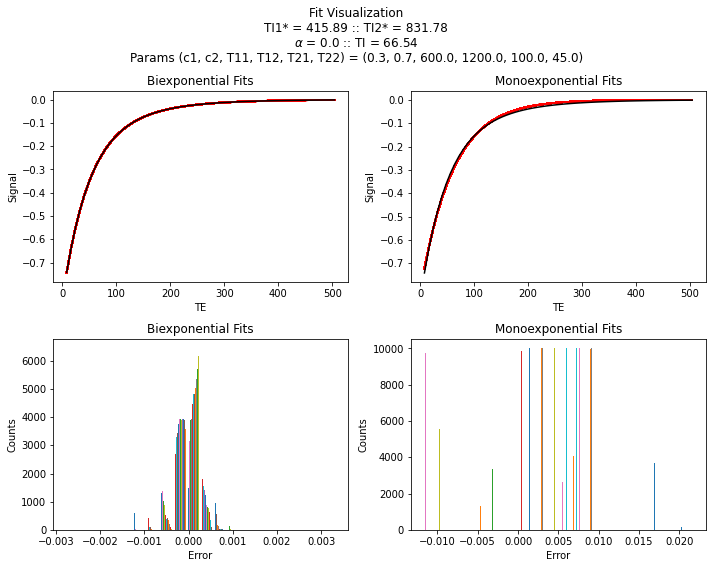

  1%|▏         | 1/71 [01:33<1:49:22, 93.75s/it]

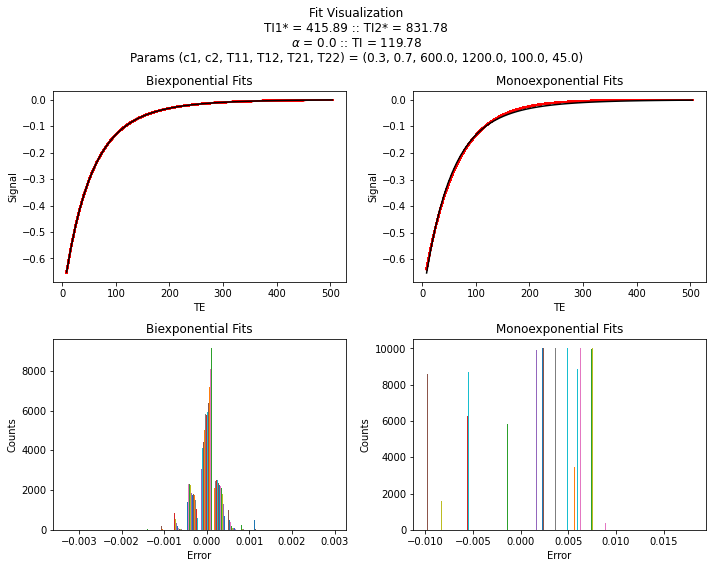

  3%|▎         | 2/71 [03:01<1:43:34, 90.07s/it]

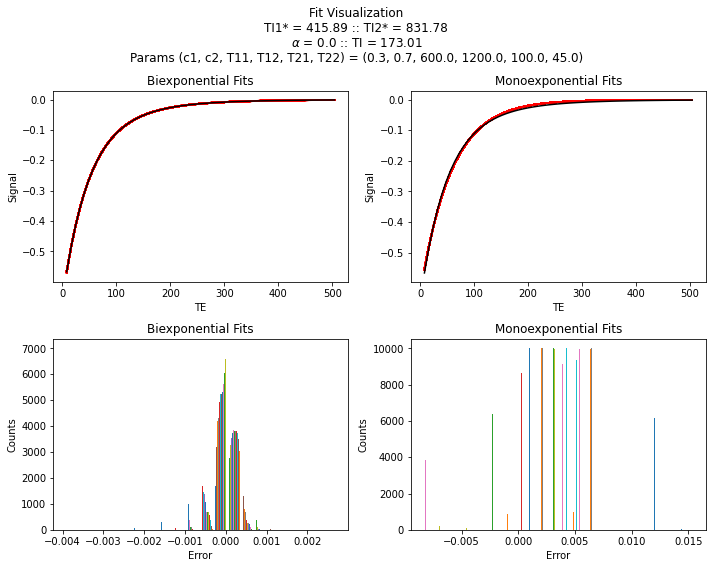

  4%|▍         | 3/71 [04:25<1:39:14, 87.57s/it]

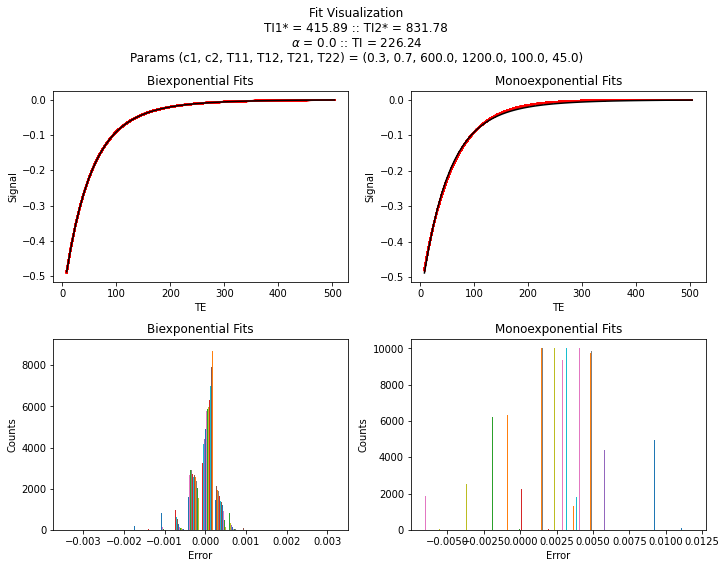

  6%|▌         | 4/71 [05:54<1:38:15, 88.00s/it]

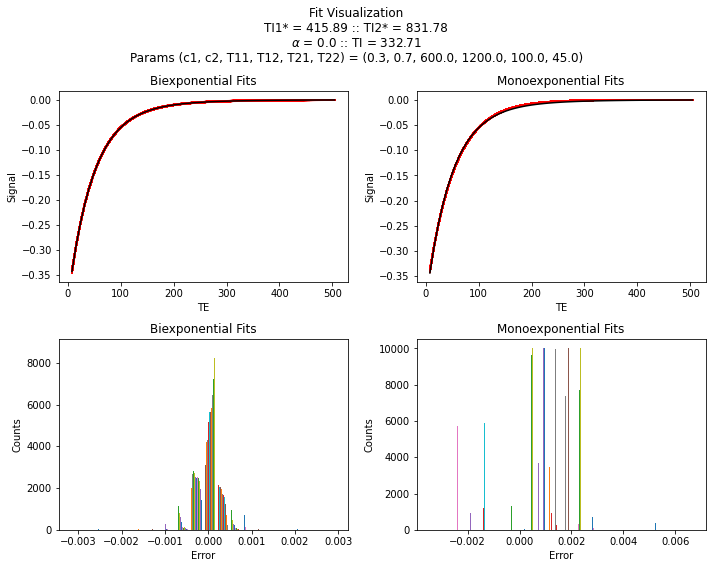

  7%|▋         | 5/71 [07:45<1:45:46, 96.16s/it]

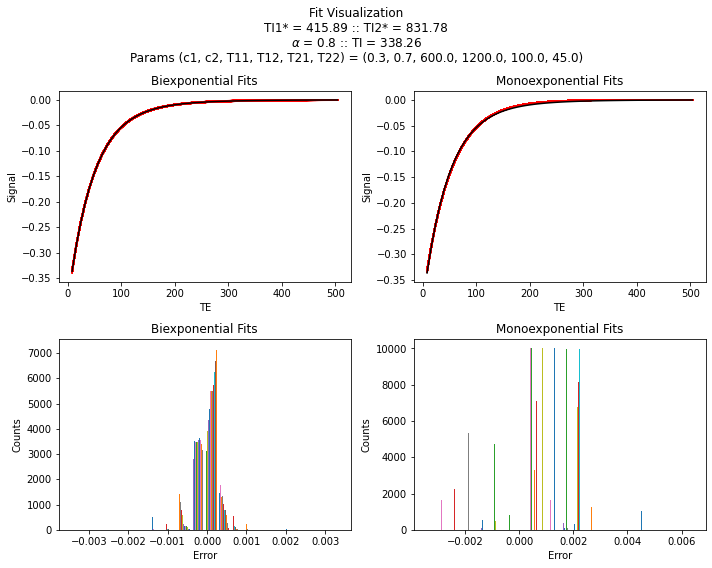

  8%|▊         | 6/71 [09:40<1:51:24, 102.84s/it]

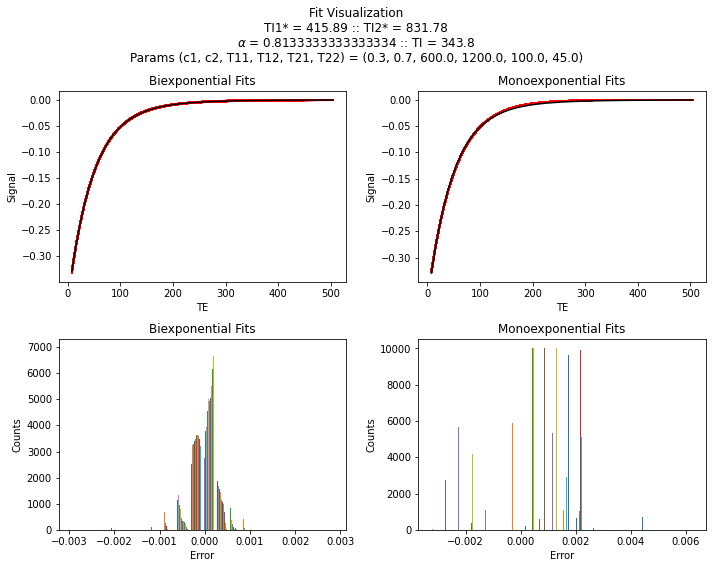

 10%|▉         | 7/71 [1:16:05<24:23:10, 1371.72s/it]

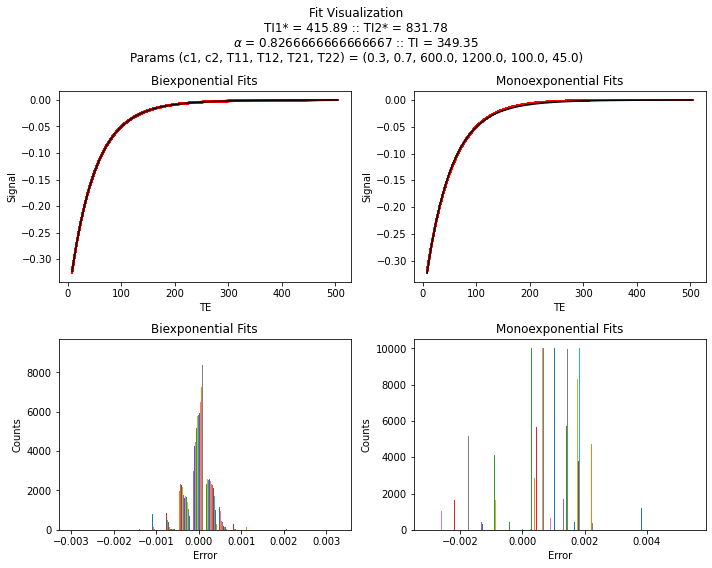

 11%|█▏        | 8/71 [1:19:12<17:24:32, 994.81s/it] 

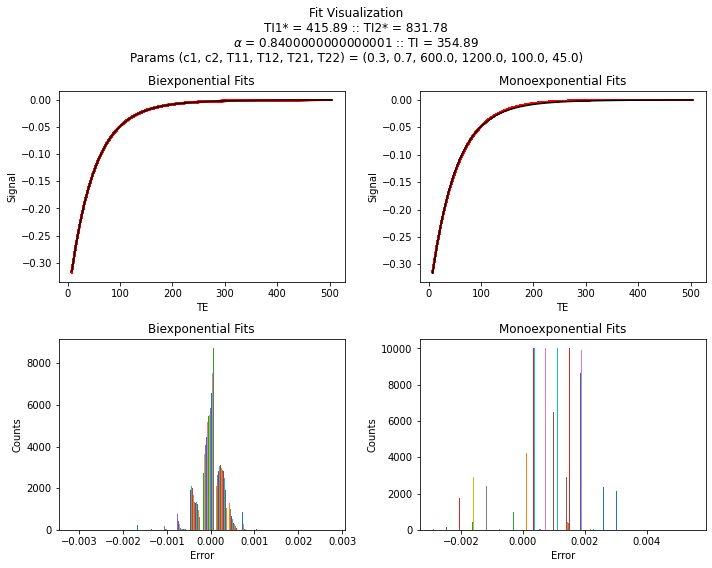

 13%|█▎        | 9/71 [1:23:54<13:17:40, 771.94s/it]

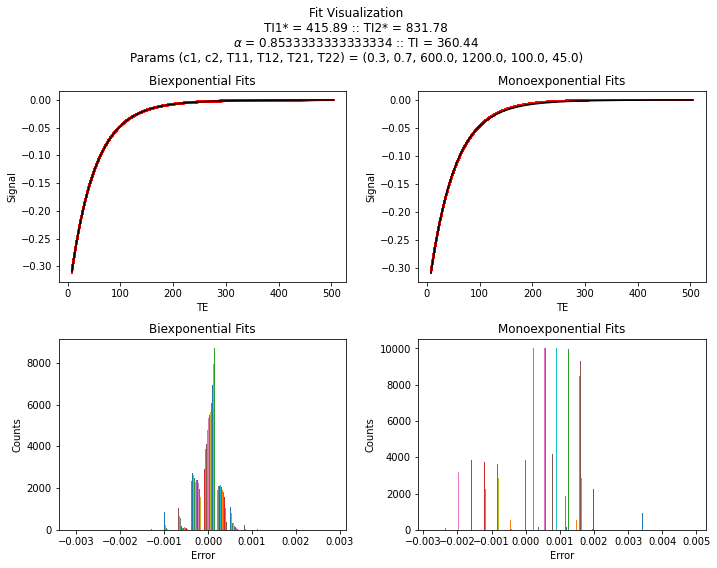

 14%|█▍        | 10/71 [1:28:25<10:27:37, 617.34s/it]

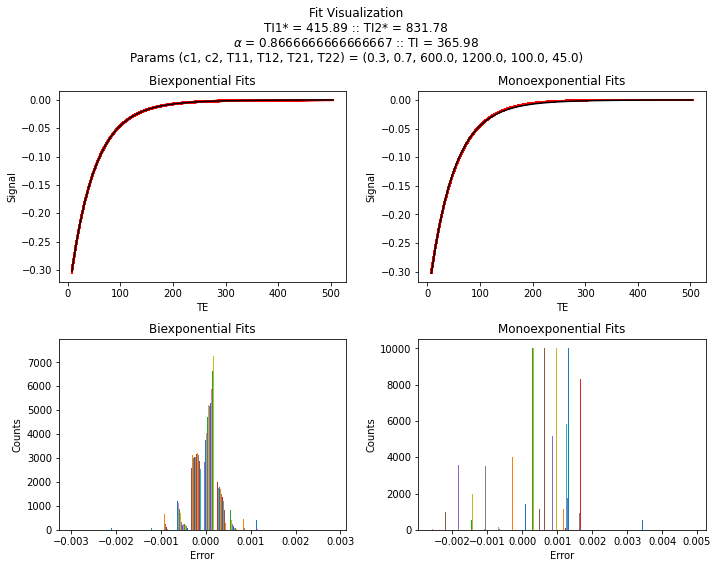

 15%|█▌        | 11/71 [3:43:13<48:23:39, 2903.67s/it]

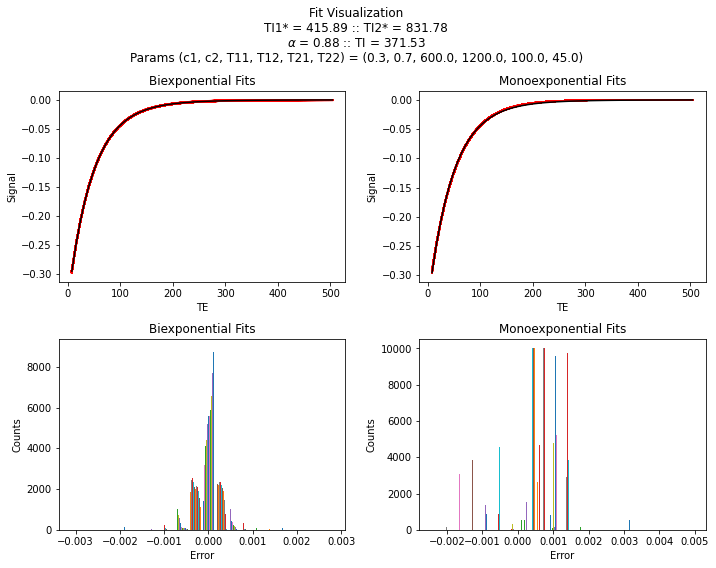

 17%|█▋        | 12/71 [3:45:37<33:49:39, 2064.06s/it]

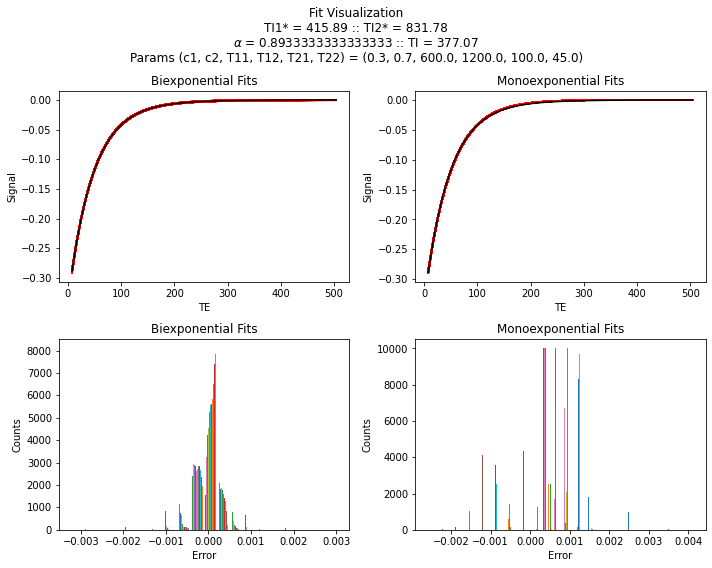

 18%|█▊        | 13/71 [3:47:14<23:39:16, 1468.21s/it]

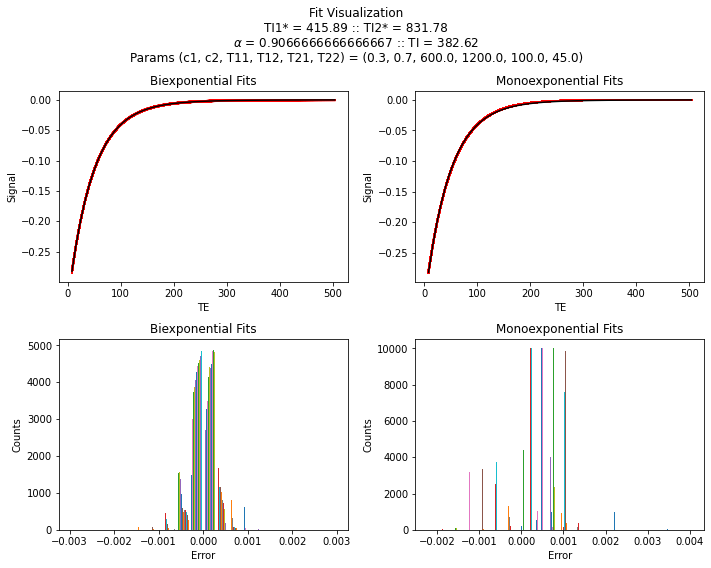

 20%|█▉        | 14/71 [3:49:01<16:44:19, 1057.18s/it]

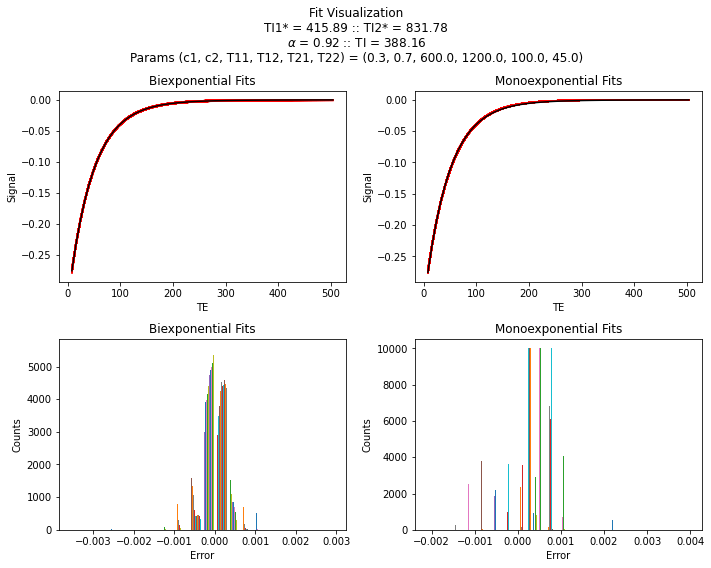

 21%|██        | 15/71 [3:51:04<12:03:40, 775.36s/it] 

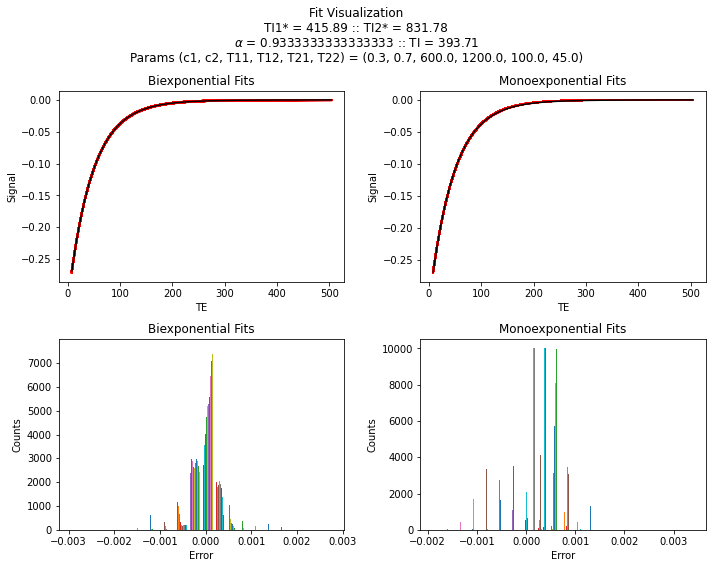

 23%|██▎       | 16/71 [3:53:18<8:53:57, 582.49s/it] 

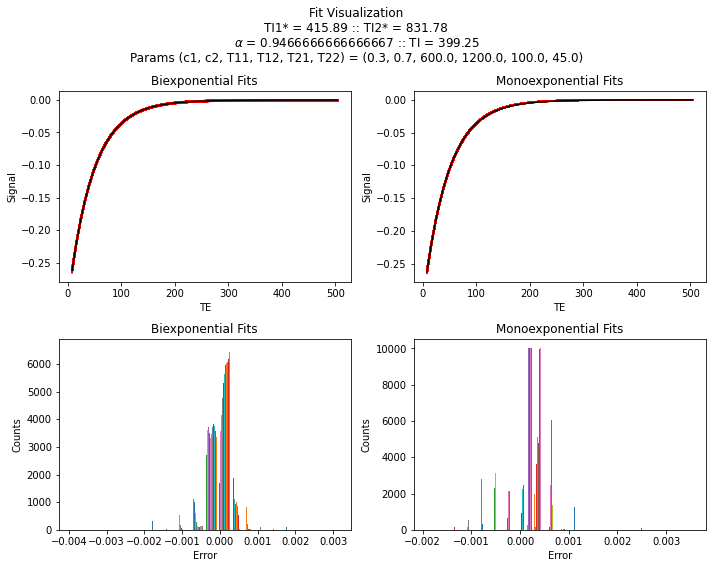

 24%|██▍       | 17/71 [3:55:55<6:48:54, 454.35s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5135


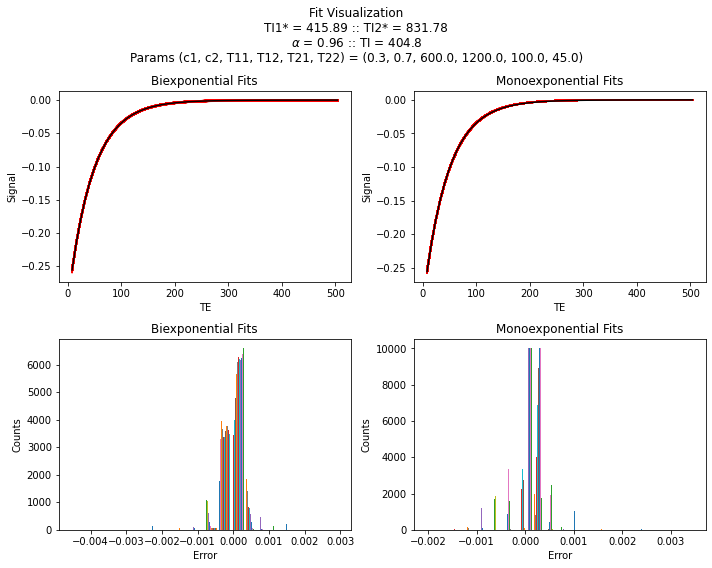

 25%|██▌       | 18/71 [3:59:07<5:31:43, 375.54s/it]

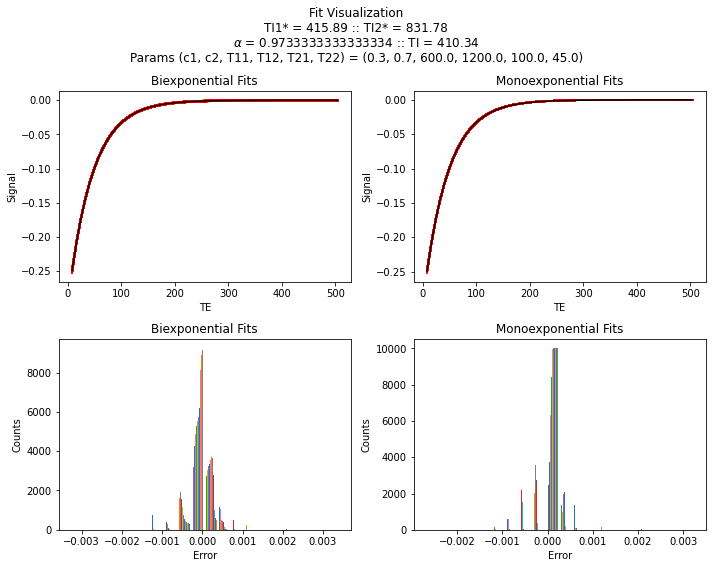

 27%|██▋       | 19/71 [4:03:31<4:56:37, 342.25s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1623
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2495
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3614
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4369
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5085
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5383
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8008
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8705
Optimal parameters not found: The maximum number of func

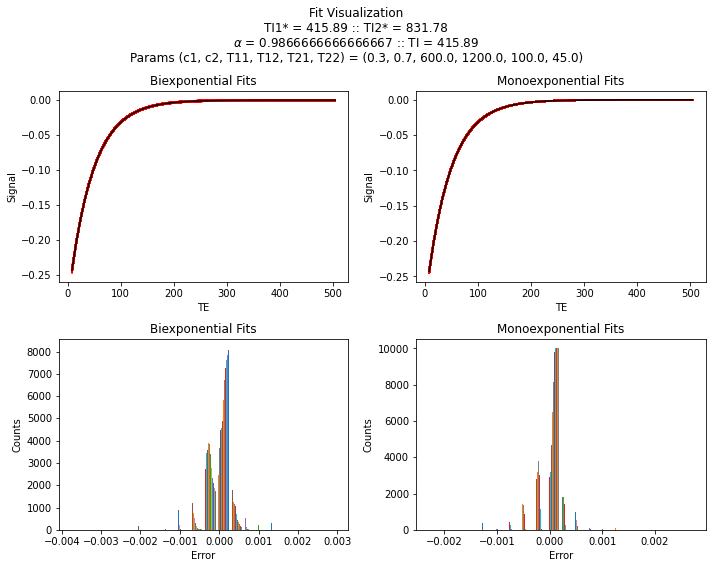

 28%|██▊       | 20/71 [4:09:36<4:56:38, 348.99s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 578
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 809
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 837
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1141
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1237
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2329
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2680
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3772
Optimal parameters not found: The maximum number of functio

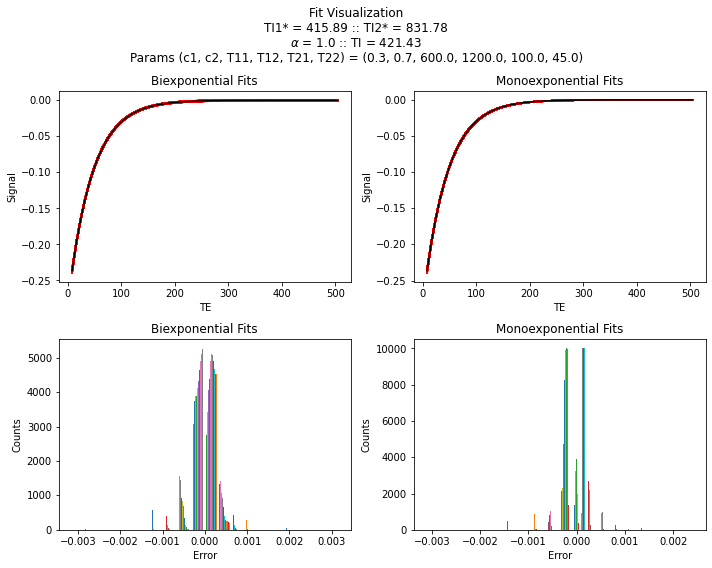

 30%|██▉       | 21/71 [4:17:15<5:18:14, 381.90s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 63
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 68
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 242
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2336
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3227
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3298
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3328
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4180
Optimal parameters not found: The maximum number of function 

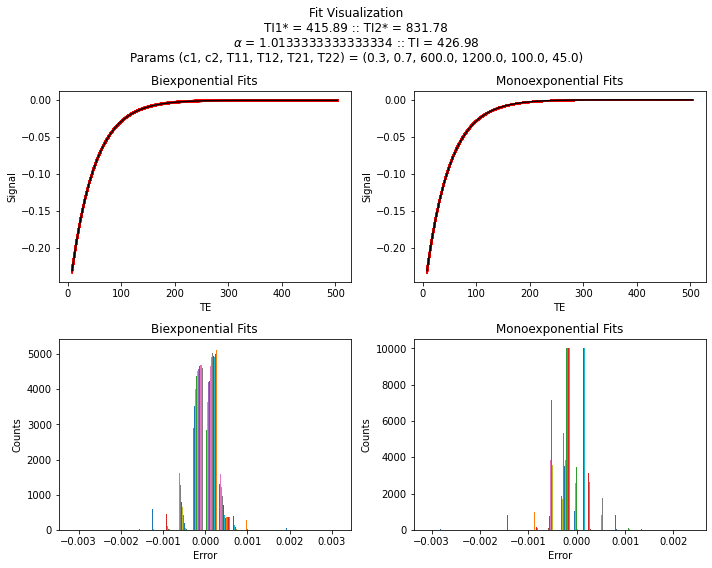

 31%|███       | 22/71 [4:24:09<5:19:55, 391.75s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 15
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 139
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 411
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 619
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 670
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 792
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 836
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1112
Optimal parameters not found: The maximum number of function eva

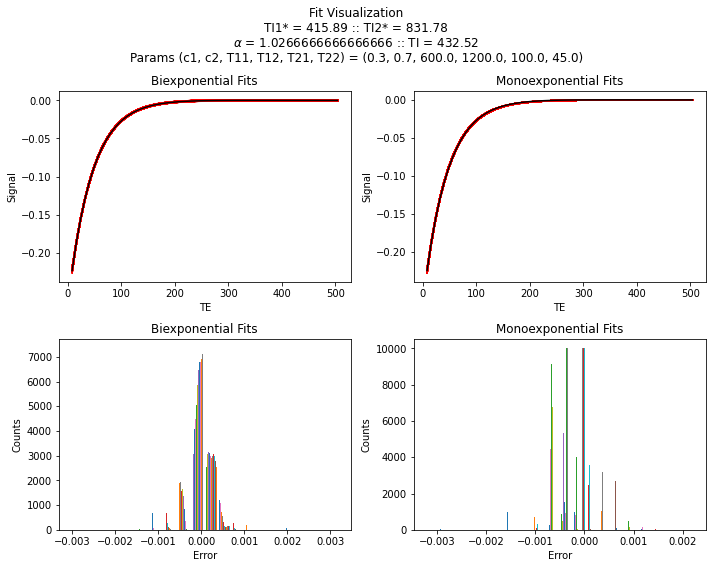

 32%|███▏      | 23/71 [4:30:33<5:11:29, 389.36s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 457
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 499
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 913
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 943
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2023
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2220
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2273
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2814
Optimal parameters not found: The maximum number of function

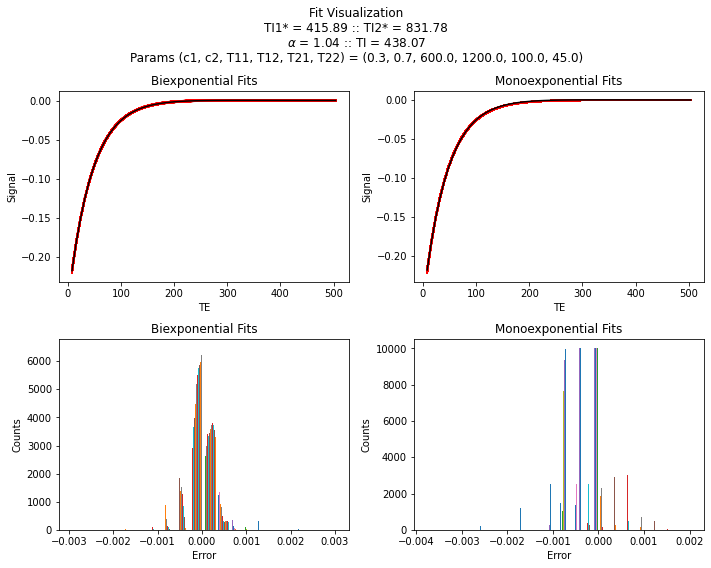

 34%|███▍      | 24/71 [4:35:58<4:49:45, 369.91s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 215
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 678
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 685
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 849
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1131
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1761
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2297
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2454
Optimal parameters not found: The maximum number of function

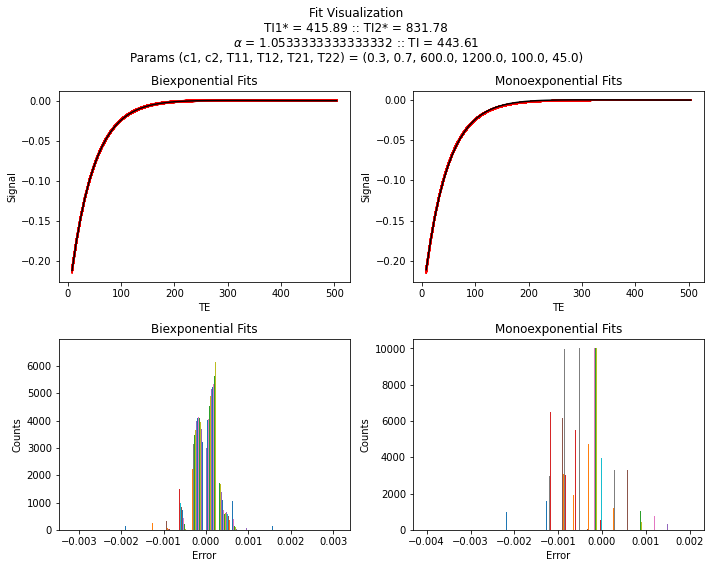

 35%|███▌      | 25/71 [4:40:37<4:22:50, 342.84s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 92
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 235
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 457
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 561
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 580
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 669
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1576
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2118
Optimal parameters not found: The maximum number of function ev

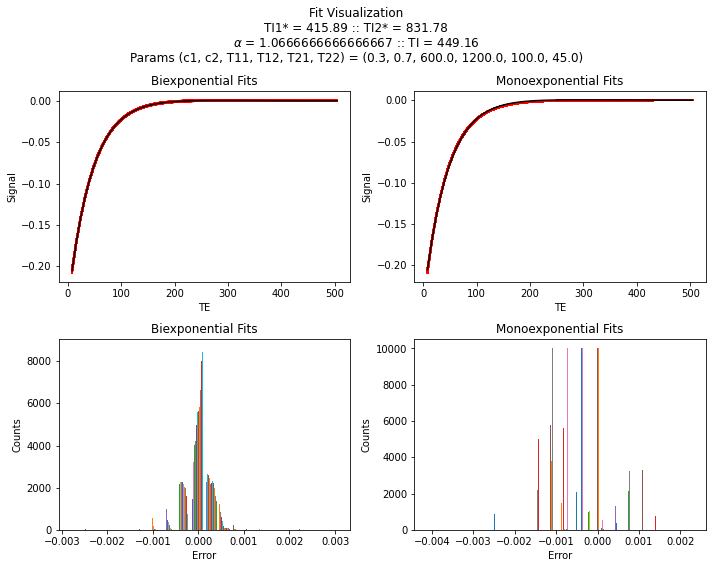

 37%|███▋      | 26/71 [4:44:46<3:56:02, 314.72s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 98
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 315
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 772
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 957
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1577
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2420
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2976
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3072
Optimal parameters not found: The maximum number of function 

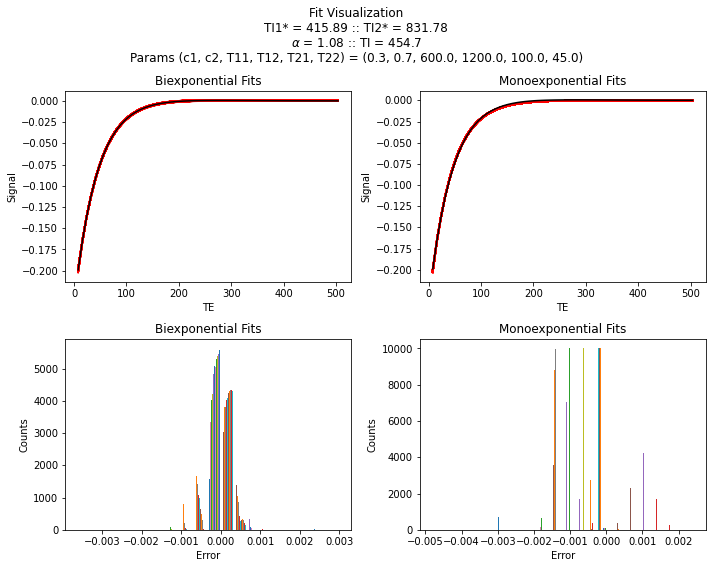

 38%|███▊      | 27/71 [4:48:28<3:30:17, 286.75s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 257
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1247
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2320
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2694
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2877
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3547
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3755
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4365
Optimal parameters not found: The maximum number of funct

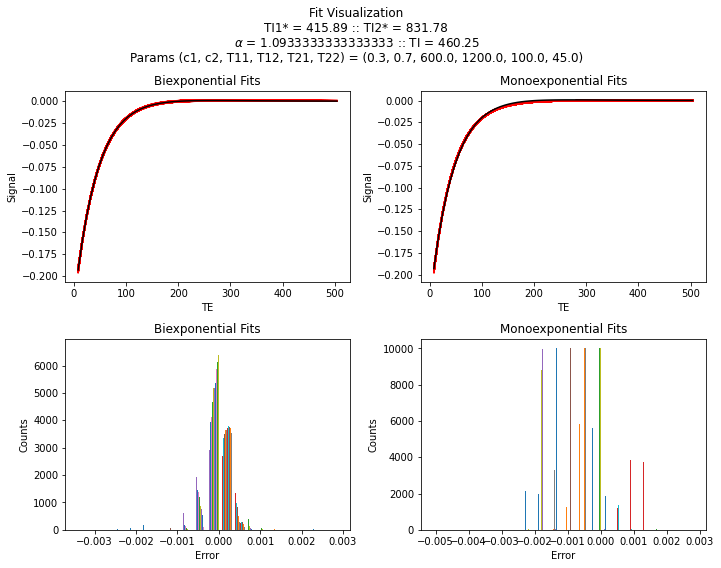

 39%|███▉      | 28/71 [4:51:41<3:05:15, 258.51s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1328
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1433
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2651
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3265
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3982
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5626
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8673


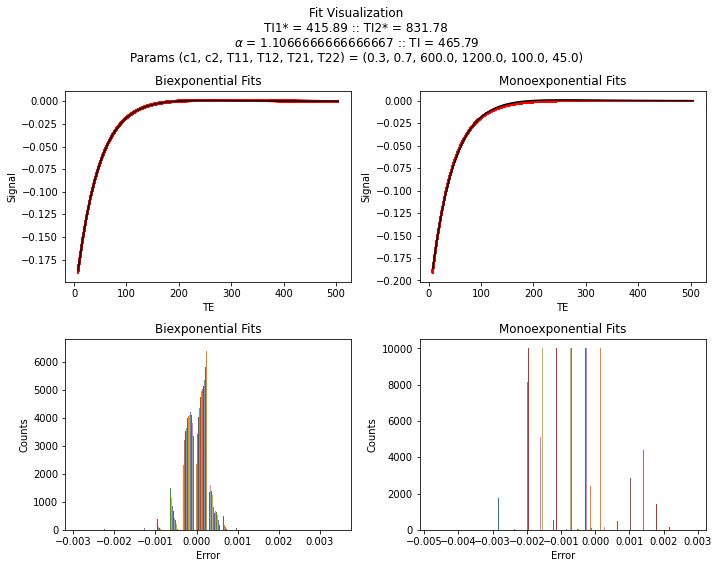

 41%|████      | 29/71 [4:54:39<2:44:03, 234.38s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 382
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1999
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2411
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3545
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4196
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4738
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5551
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6083
Optimal parameters not found: The maximum number of funct

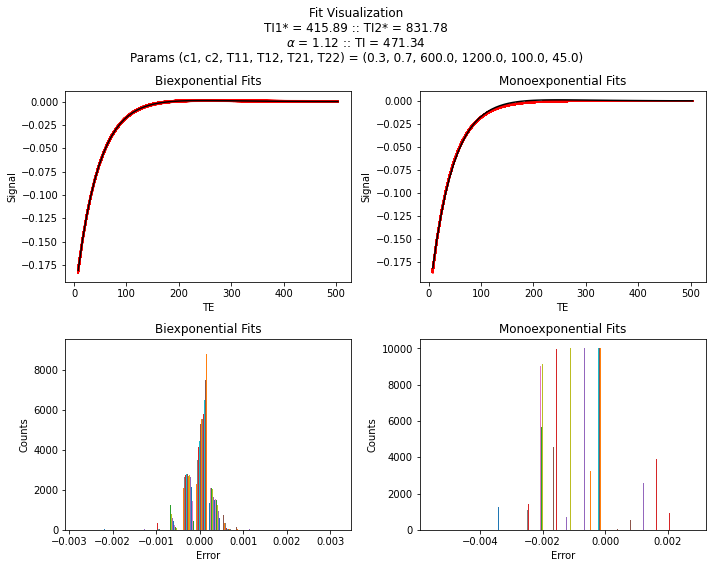

 42%|████▏     | 30/71 [4:57:18<2:24:48, 211.91s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1909
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2601
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4283
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7111
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7399
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7703
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8197
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8613
Optimal parameters not found: The maximum number of func

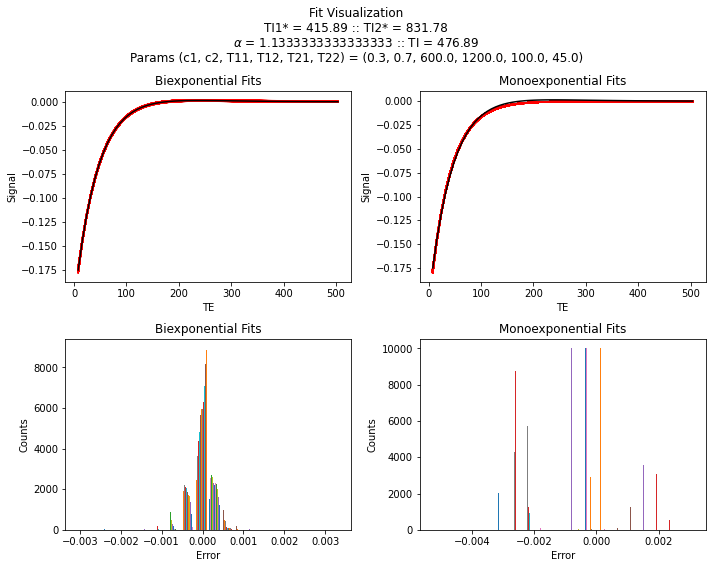

 44%|████▎     | 31/71 [4:59:49<2:09:03, 193.58s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3170


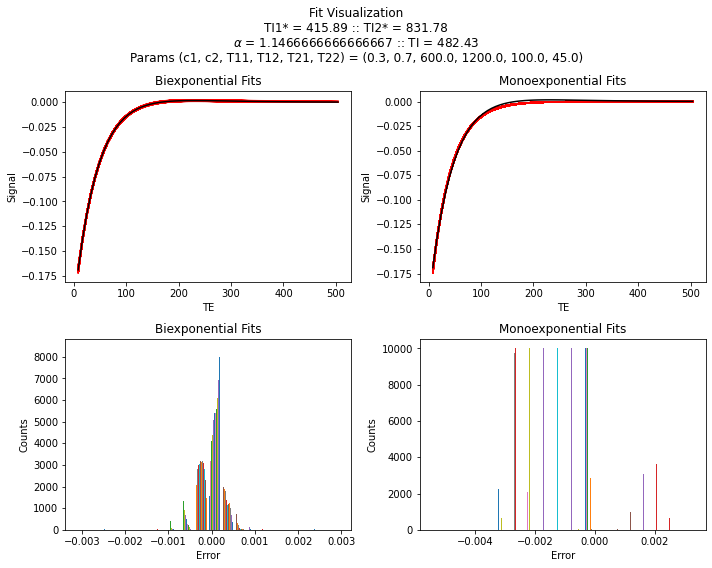

 45%|████▌     | 32/71 [5:01:58<1:53:14, 174.21s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4886


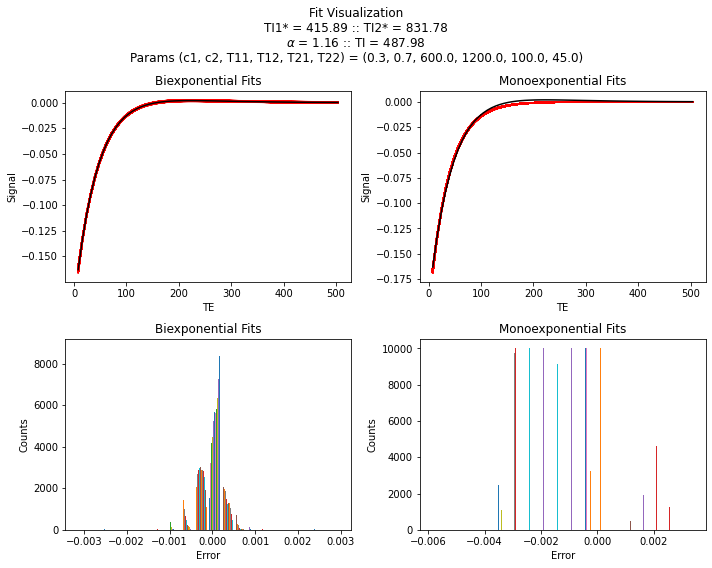

 46%|████▋     | 33/71 [5:04:00<1:40:21, 158.46s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2303


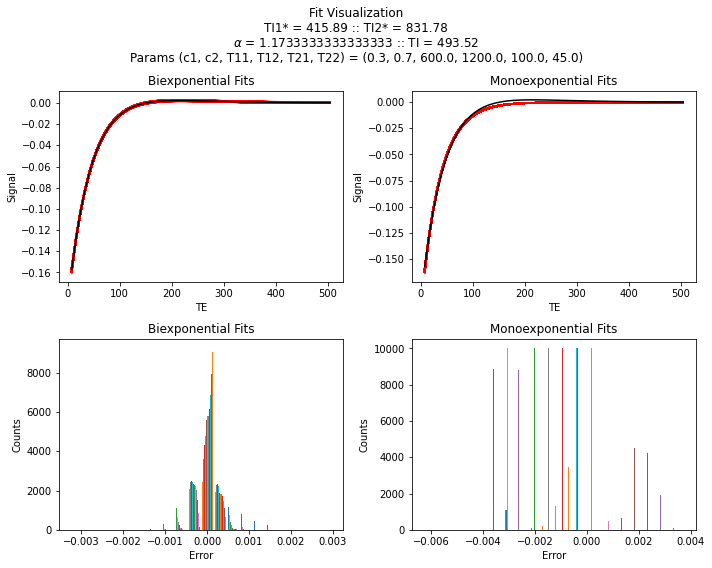

 48%|████▊     | 34/71 [5:06:01<1:30:53, 147.40s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5267


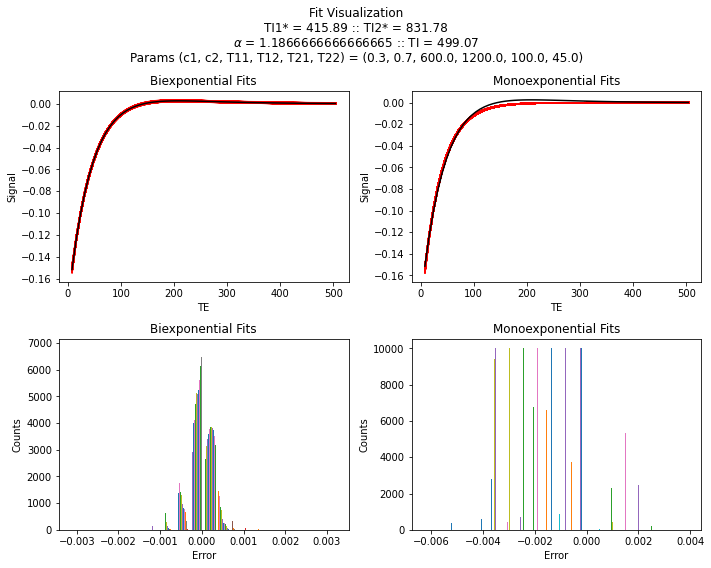

 49%|████▉     | 35/71 [5:07:58<1:22:57, 138.27s/it]

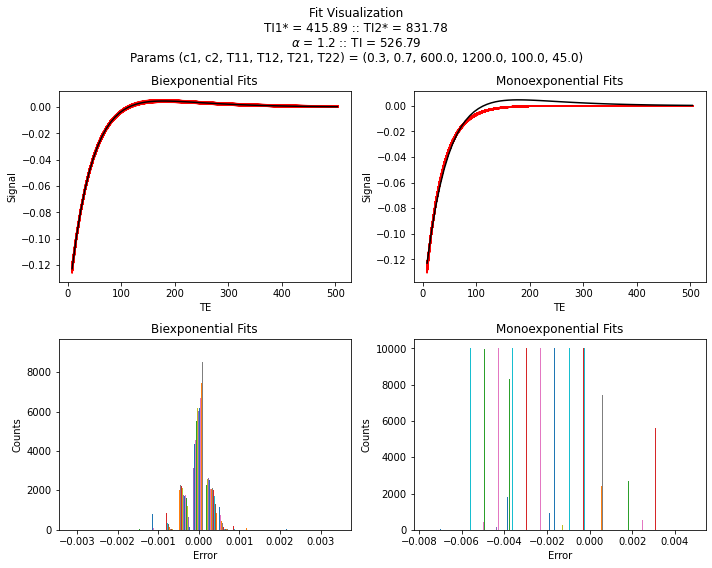

 51%|█████     | 36/71 [5:09:49<1:15:53, 130.09s/it]

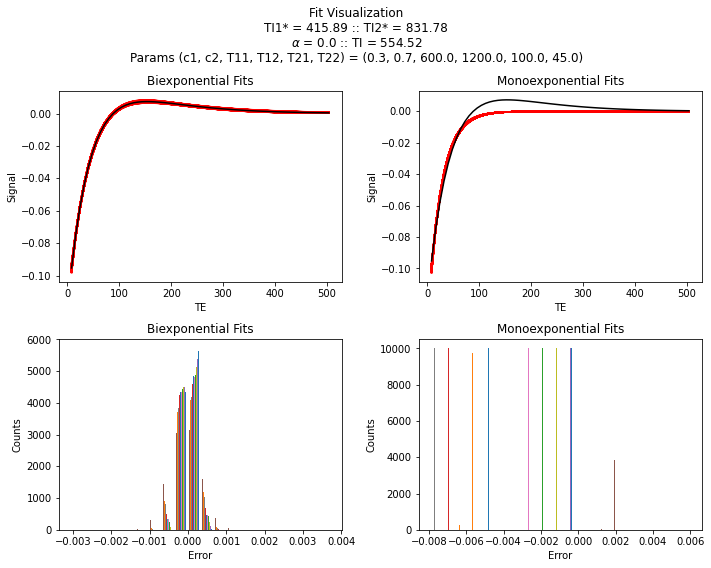

 52%|█████▏    | 37/71 [5:11:37<1:09:53, 123.33s/it]

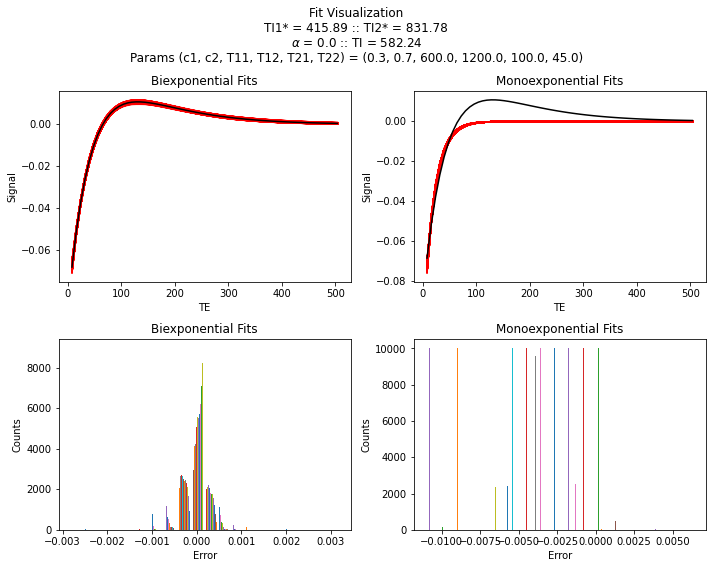

 54%|█████▎    | 38/71 [5:13:42<1:08:05, 123.80s/it]

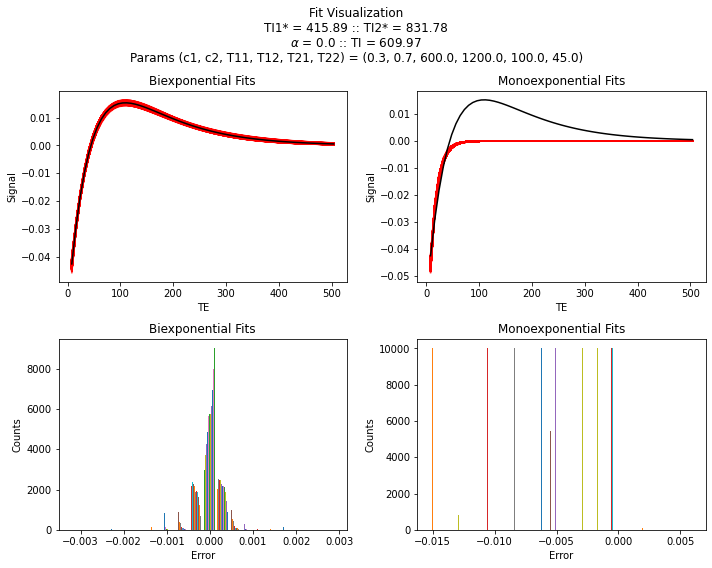

 55%|█████▍    | 39/71 [5:16:05<1:09:06, 129.56s/it]

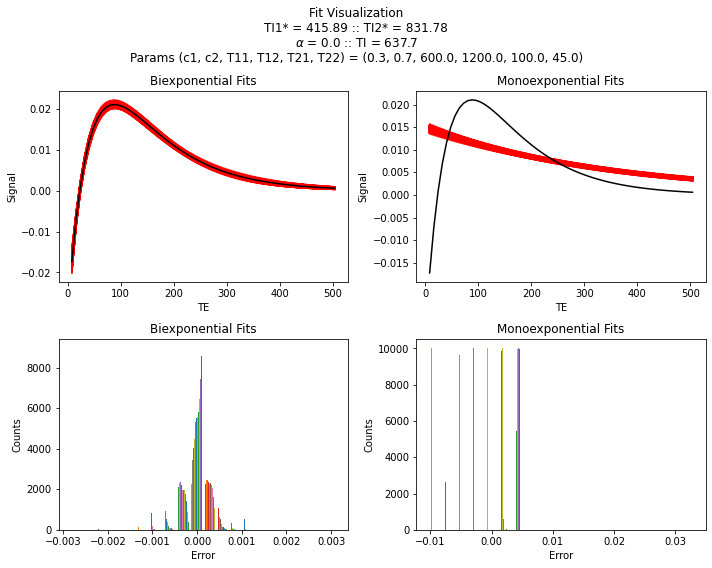

 56%|█████▋    | 40/71 [5:18:24<1:08:23, 132.38s/it]

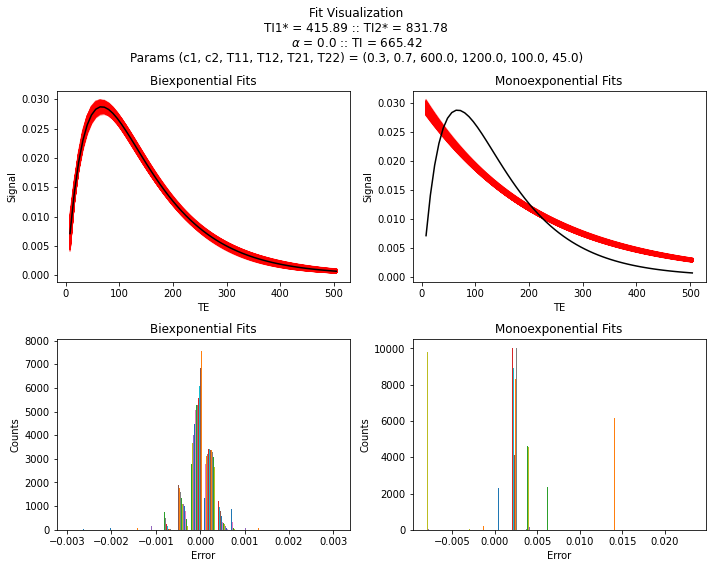

 58%|█████▊    | 41/71 [5:20:20<1:03:50, 127.69s/it]

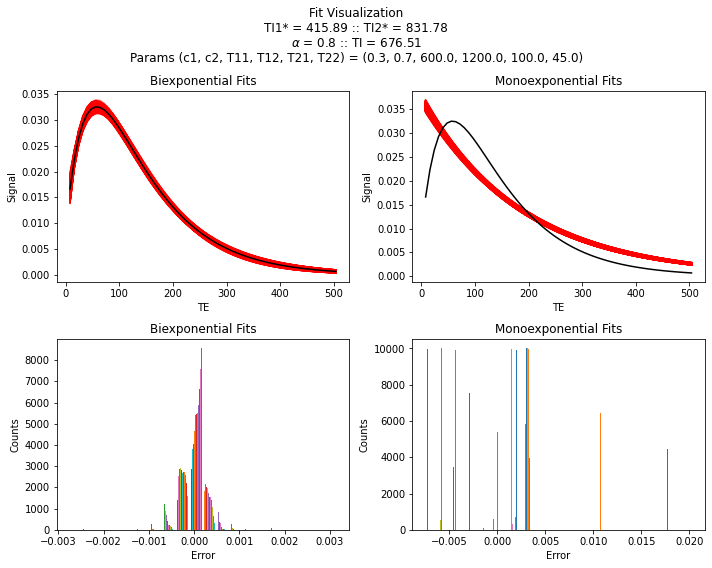

 59%|█████▉    | 42/71 [5:21:58<57:23, 118.73s/it]  

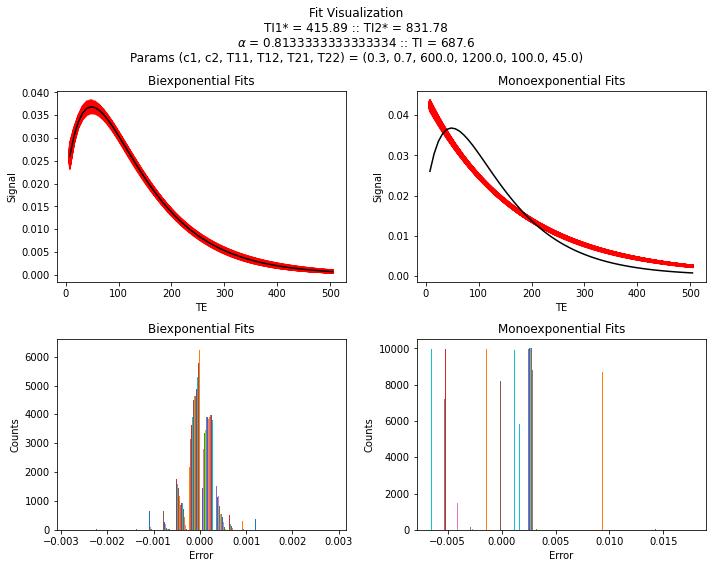

 61%|██████    | 43/71 [5:23:39<52:51, 113.28s/it]

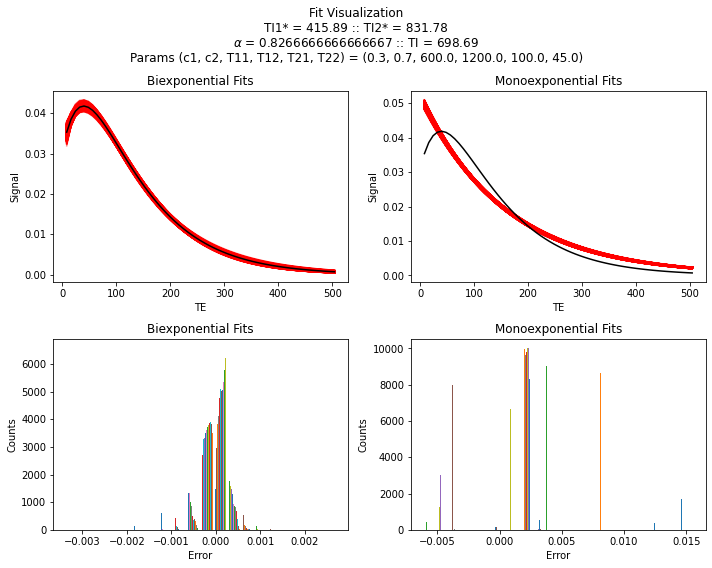

 62%|██████▏   | 44/71 [5:25:22<49:34, 110.16s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3921
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4329


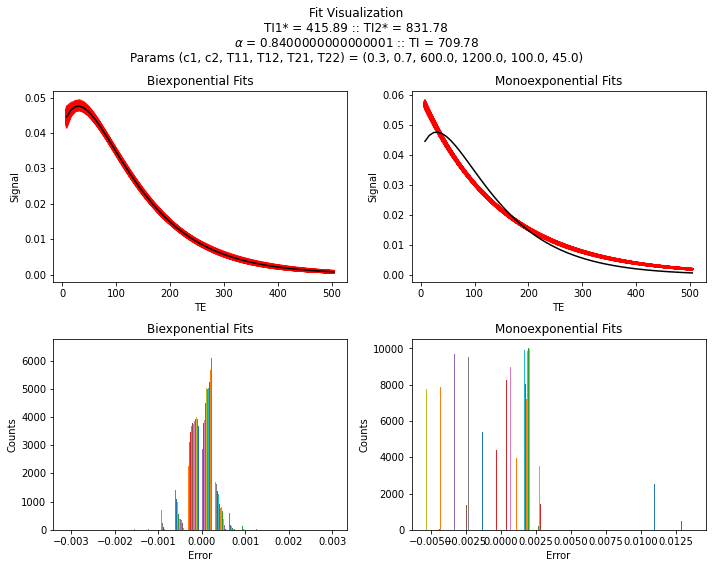

 63%|██████▎   | 45/71 [5:27:04<46:41, 107.75s/it]

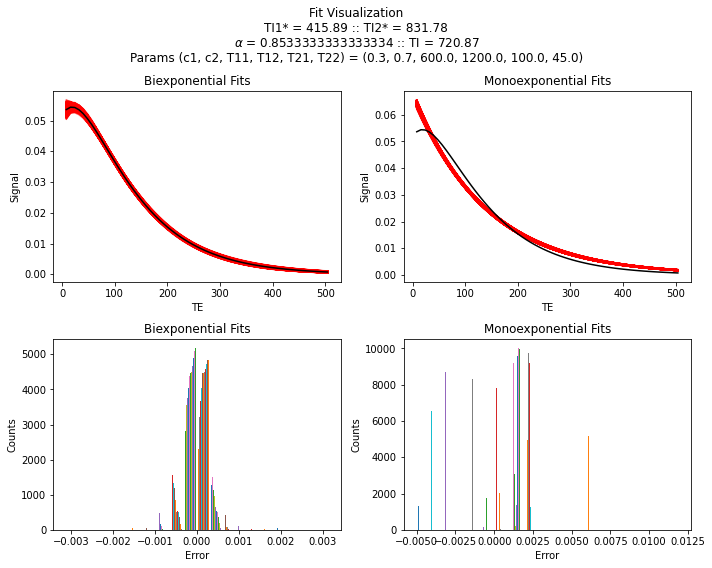

 65%|██████▍   | 46/71 [5:28:51<44:50, 107.64s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1603
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3956
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6028
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 6965


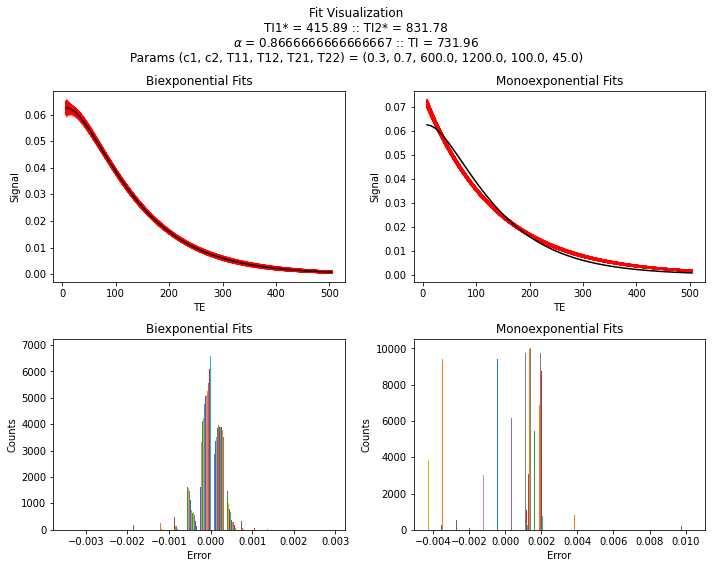

 66%|██████▌   | 47/71 [5:30:53<44:48, 112.04s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 4290


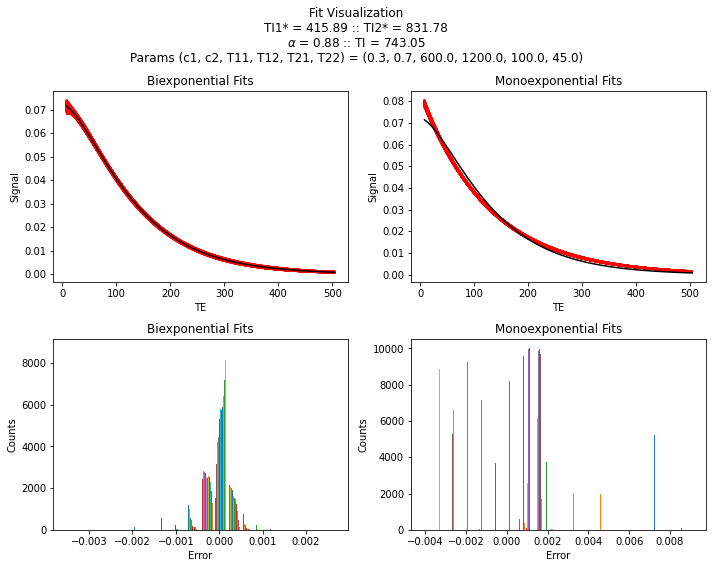

 68%|██████▊   | 48/71 [5:33:06<45:17, 118.14s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1832
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3372
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3490
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5521
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7127
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8404
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 8756


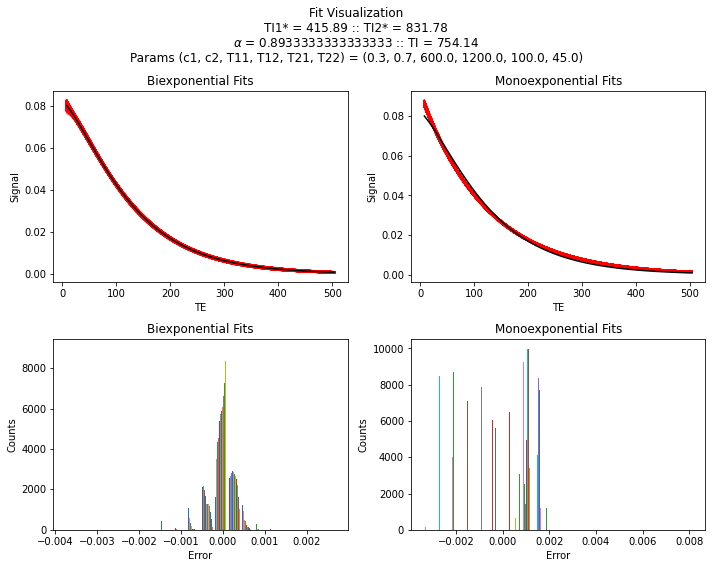

 69%|██████▉   | 49/71 [5:35:38<47:00, 128.22s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1346
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1571
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2079
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2167
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2544
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3521
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3629
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3983
Optimal parameters not found: The maximum number of func

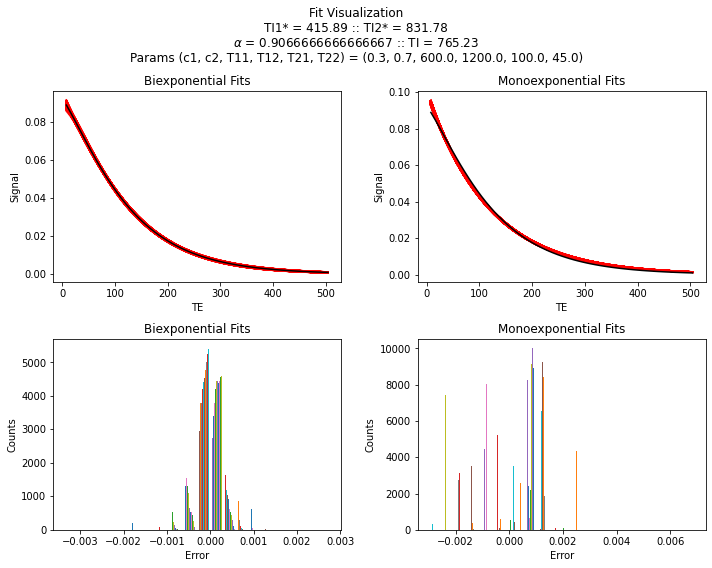

 70%|███████   | 50/71 [5:38:40<50:32, 144.40s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1675
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1823
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2208
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2429
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2933
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3029
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3054
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 3531
Optimal parameters not found: The maximum number of func

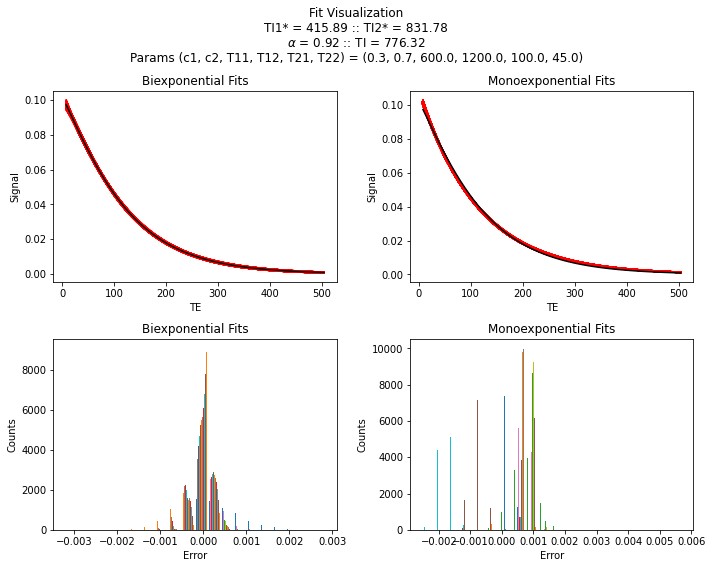

 72%|███████▏  | 51/71 [5:42:10<54:44, 164.24s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 198
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 356
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 375
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 414
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 509
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 731
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 906
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 940
Optimal parameters not found: The maximum number of function eva

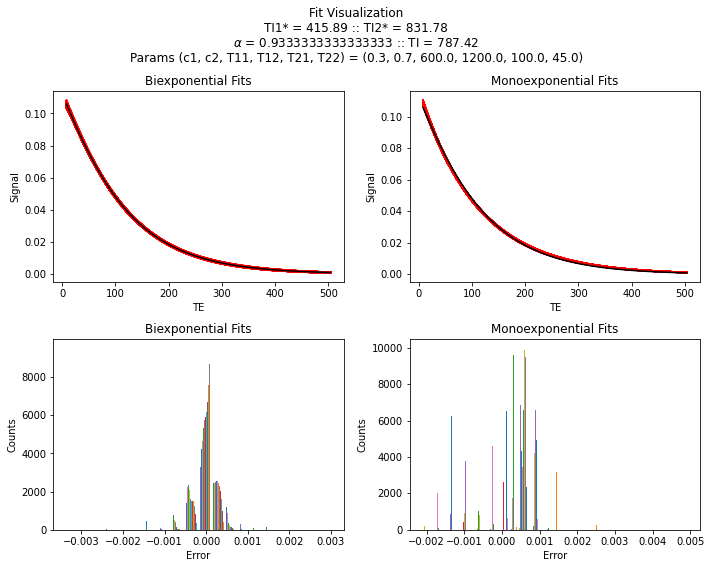

 73%|███████▎  | 52/71 [5:46:43<1:02:20, 196.89s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 16
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 56
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 89
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 117
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 158
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 179
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 208
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 271
Optimal parameters not found: The maximum number of function evalua

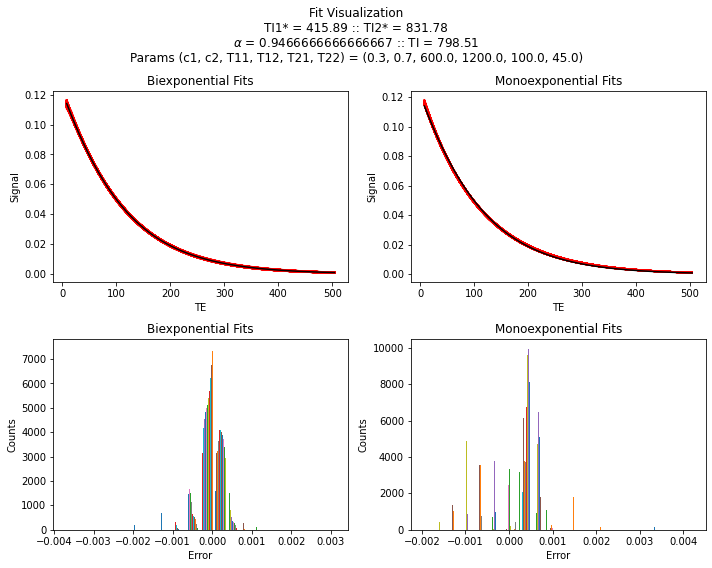

 75%|███████▍  | 53/71 [5:52:31<1:12:39, 242.20s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 87
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 91
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 96
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 106
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 308
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 318
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 502
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 546
Optimal parameters not found: The maximum number of function evalua

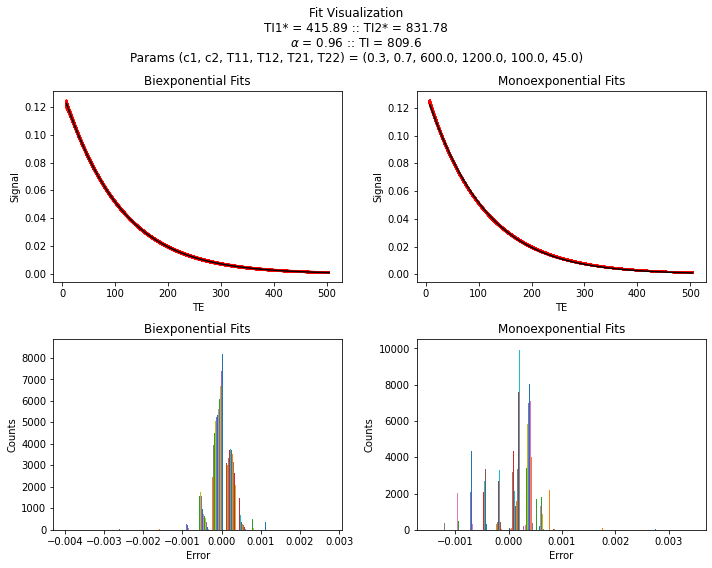

 76%|███████▌  | 54/71 [5:59:51<1:25:24, 301.44s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 27
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 31
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 47
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 130
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 228
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 230
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 232
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 287
Optimal parameters not found: The maximum number of function evalua

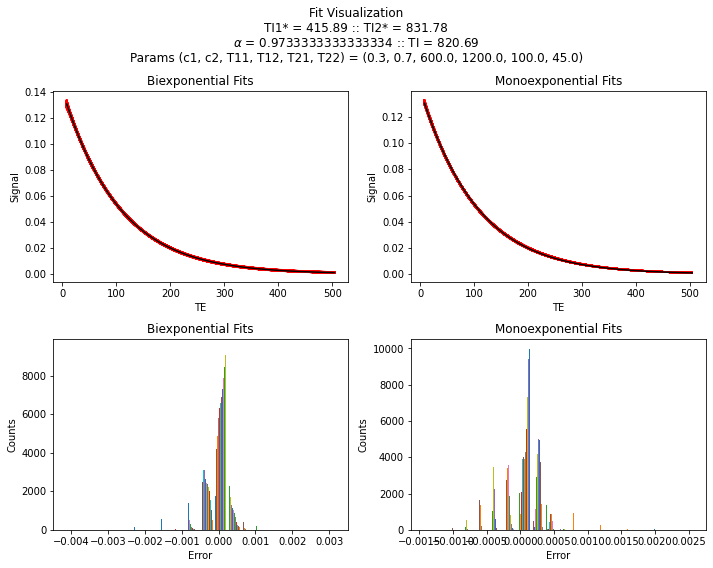

 77%|███████▋  | 55/71 [6:08:18<1:36:51, 363.20s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 152
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 747
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1233
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1484
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 1980
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2153
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2189
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 2301
Optimal parameters not found: The maximum number of functi

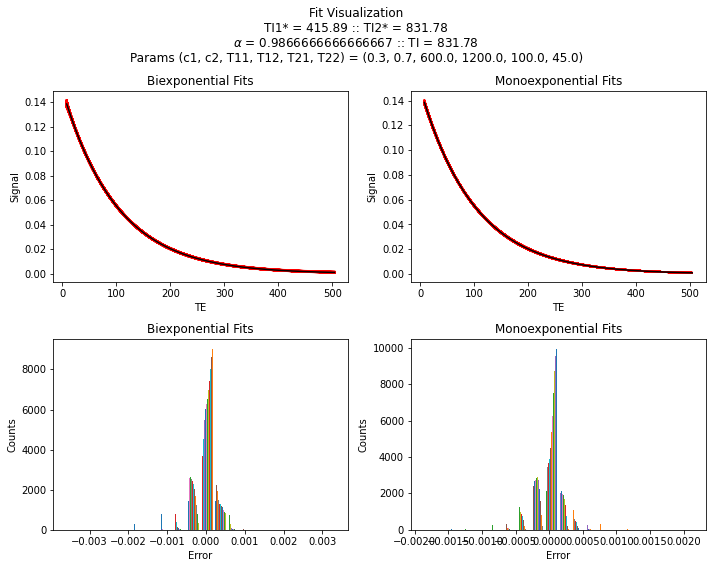

 79%|███████▉  | 56/71 [6:15:21<1:35:14, 380.94s/it]

Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5508
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 5665
Optimal parameters not found: The maximum number of function evaluations is exceeded.
Rerunning this iteration = 7841


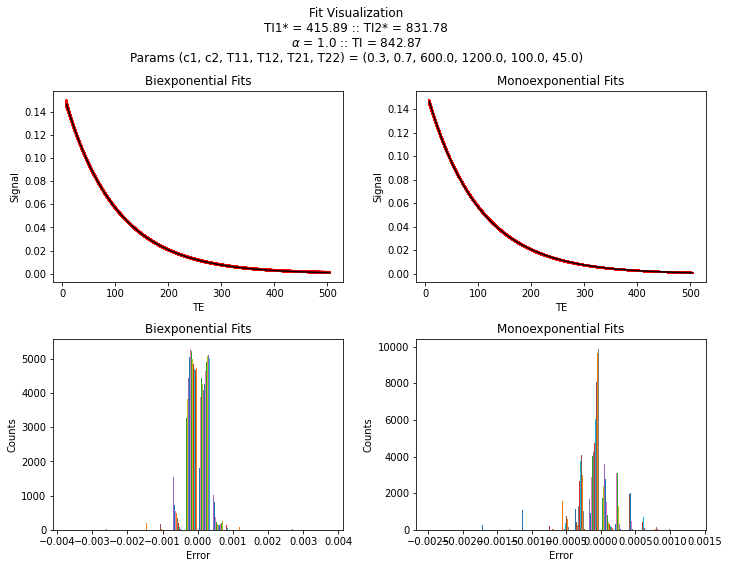

 80%|████████  | 57/71 [6:19:20<1:18:59, 338.54s/it]

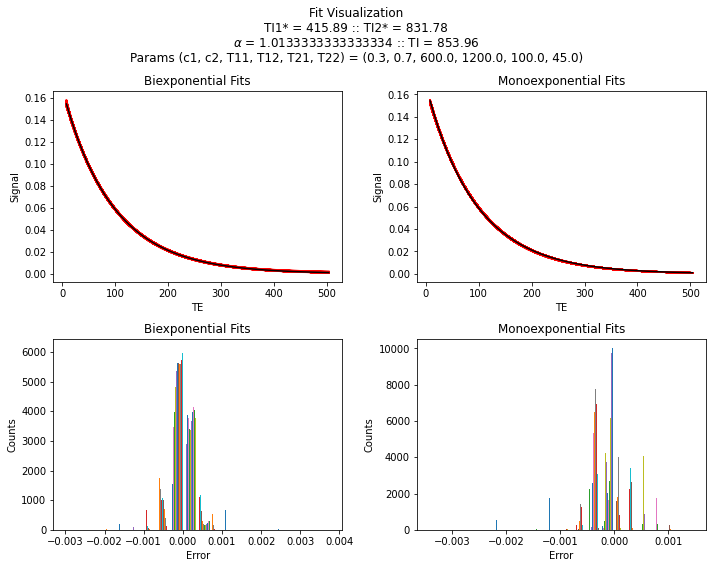

 82%|████████▏ | 58/71 [6:21:49<1:01:01, 281.65s/it]

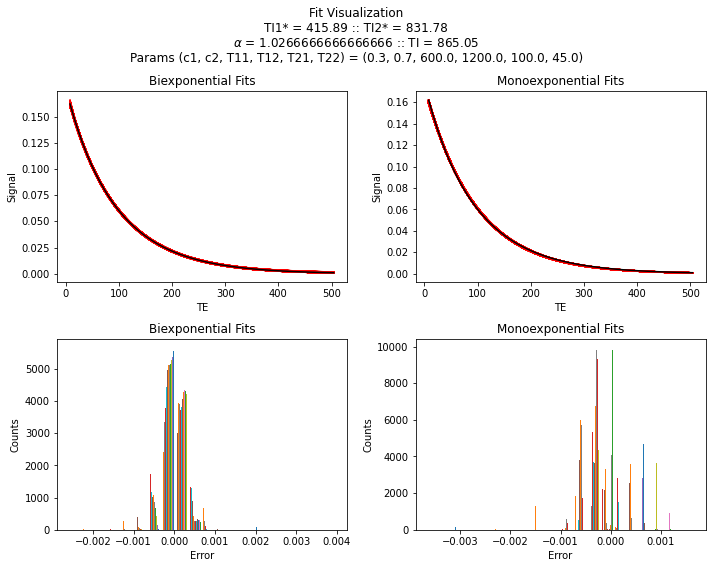

 83%|████████▎ | 59/71 [6:23:47<46:31, 232.61s/it]  

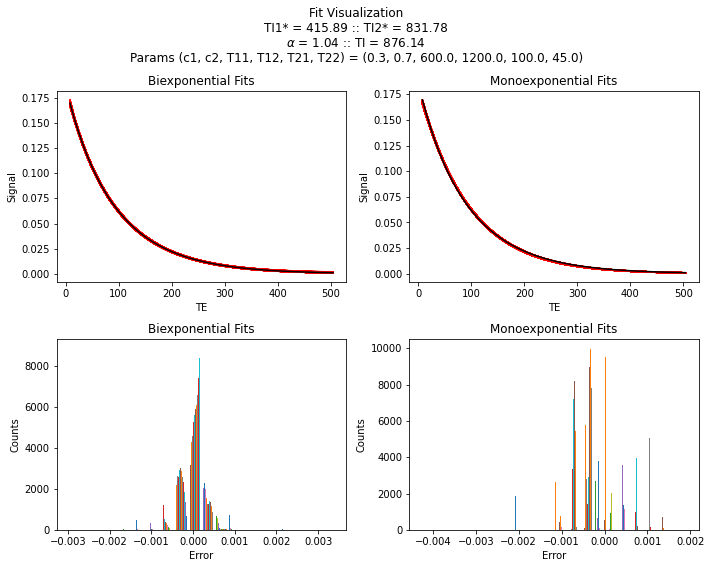

 85%|████████▍ | 60/71 [6:25:32<35:36, 194.27s/it]

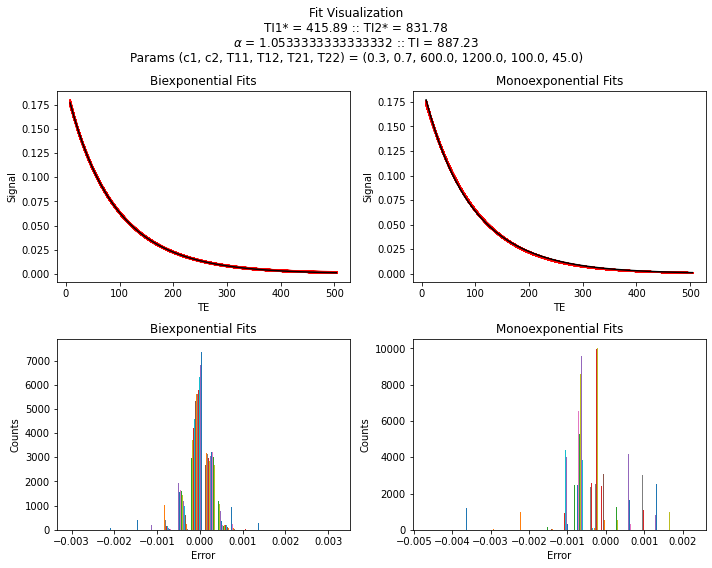

 86%|████████▌ | 61/71 [6:27:07<27:23, 164.32s/it]

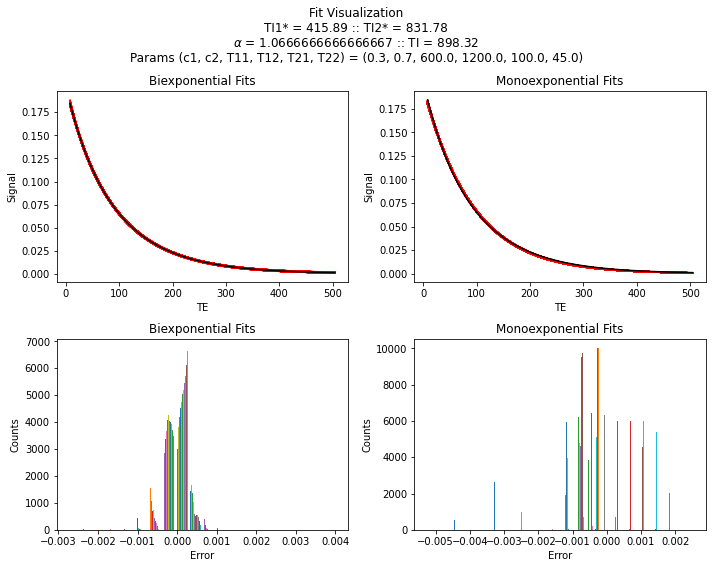

 87%|████████▋ | 62/71 [6:28:37<21:20, 142.28s/it]

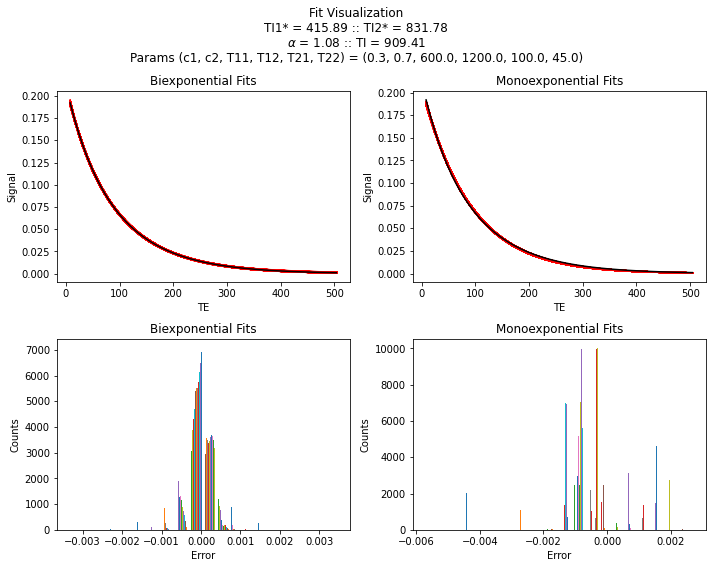

 89%|████████▊ | 63/71 [6:29:59<16:32, 124.10s/it]

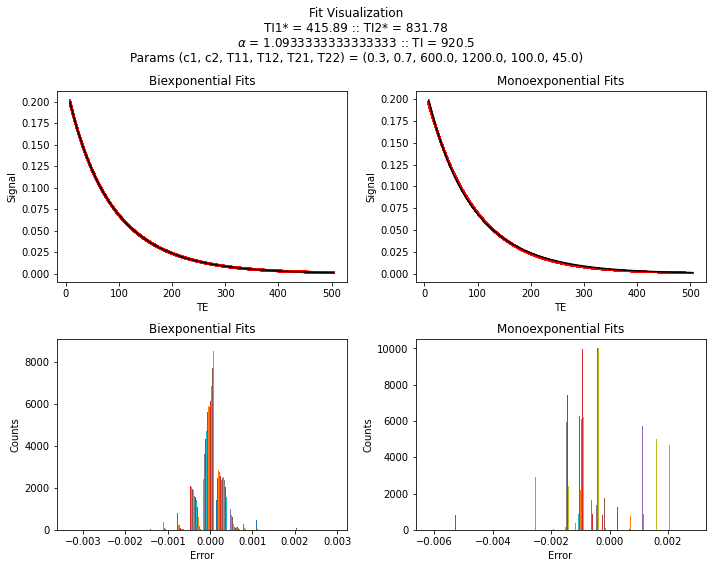

 90%|█████████ | 64/71 [6:31:29<13:17, 113.91s/it]

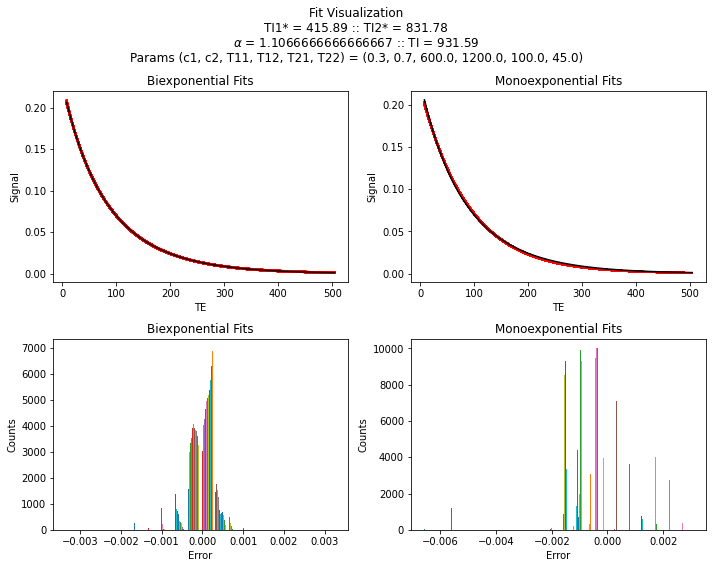

 92%|█████████▏| 65/71 [6:32:43<10:11, 101.98s/it]

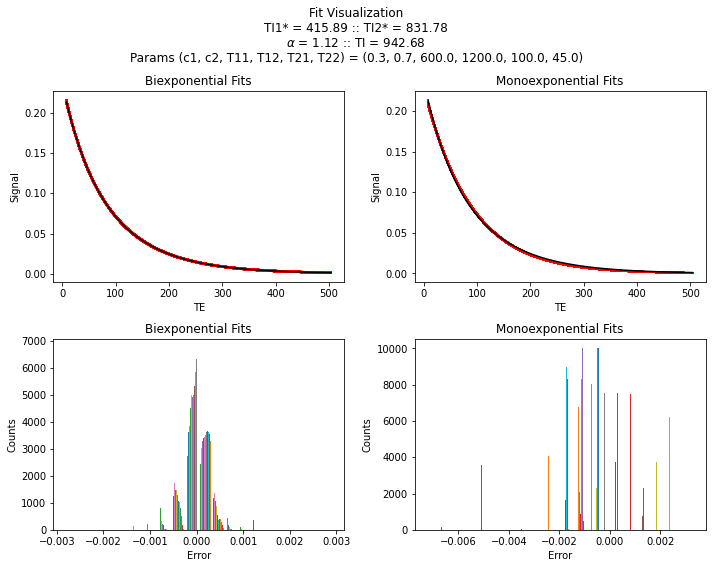

 93%|█████████▎| 66/71 [6:33:55<07:44, 92.87s/it] 

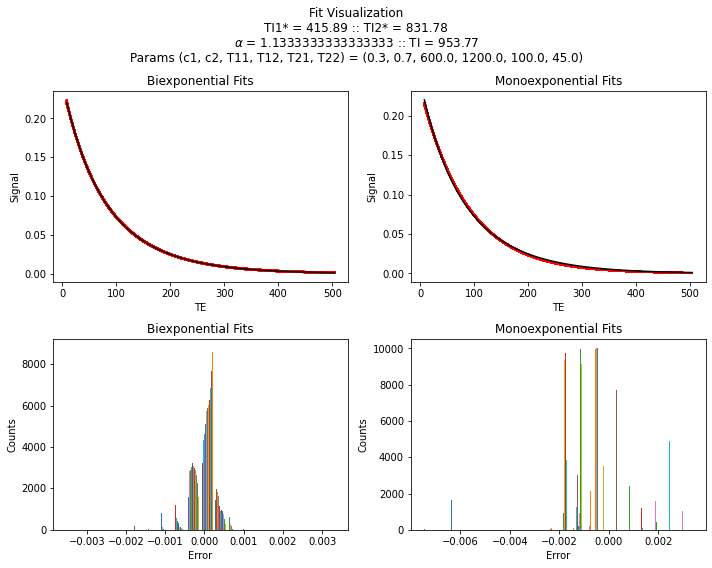

 94%|█████████▍| 67/71 [6:35:05<05:44, 86.11s/it]

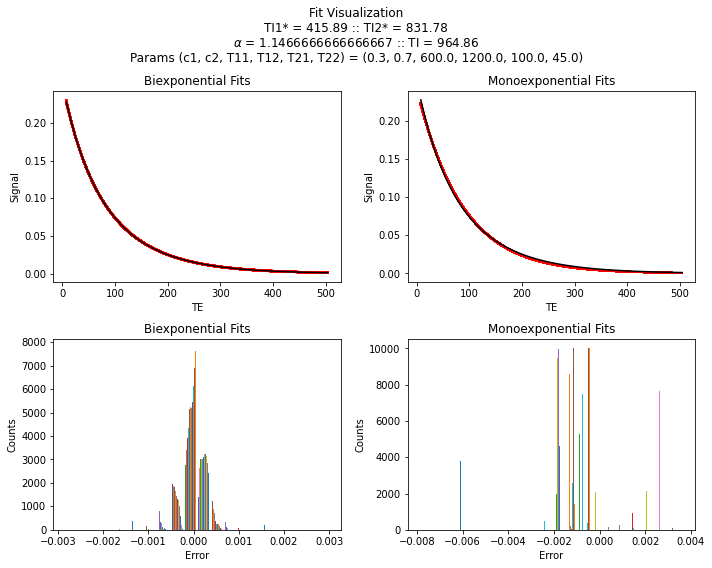

 96%|█████████▌| 68/71 [6:36:15<04:03, 81.31s/it]

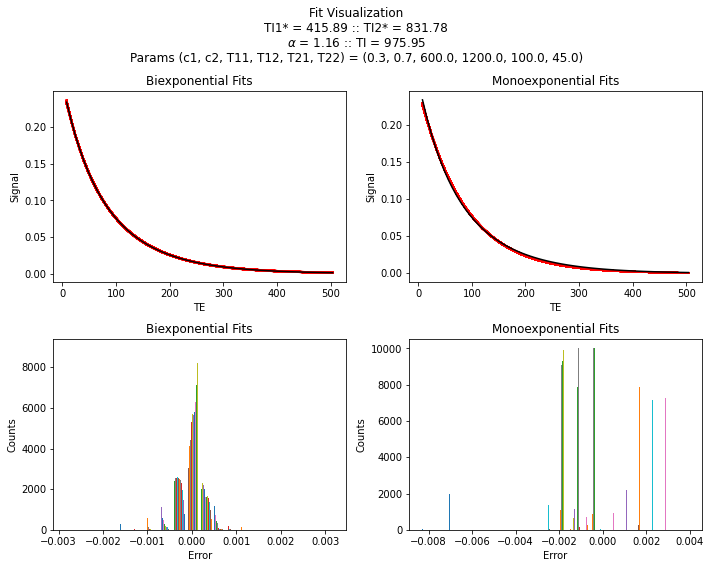

 97%|█████████▋| 69/71 [6:37:24<02:35, 77.56s/it]

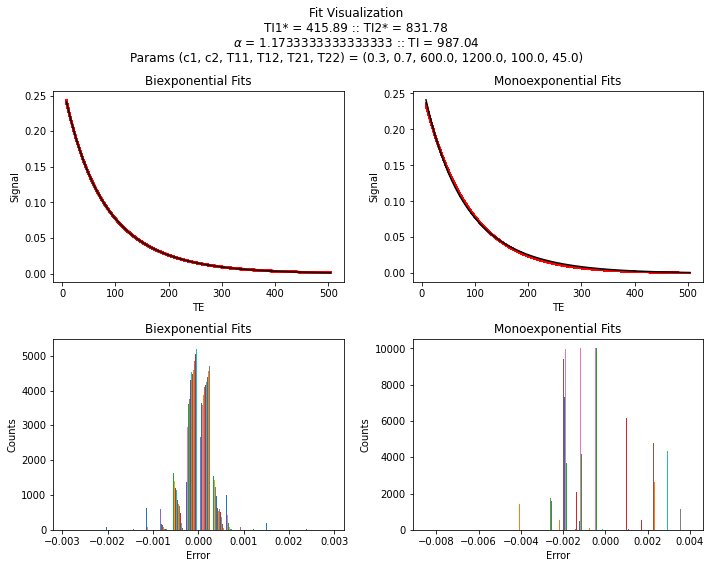

 99%|█████████▊| 70/71 [6:38:33<01:14, 74.83s/it]

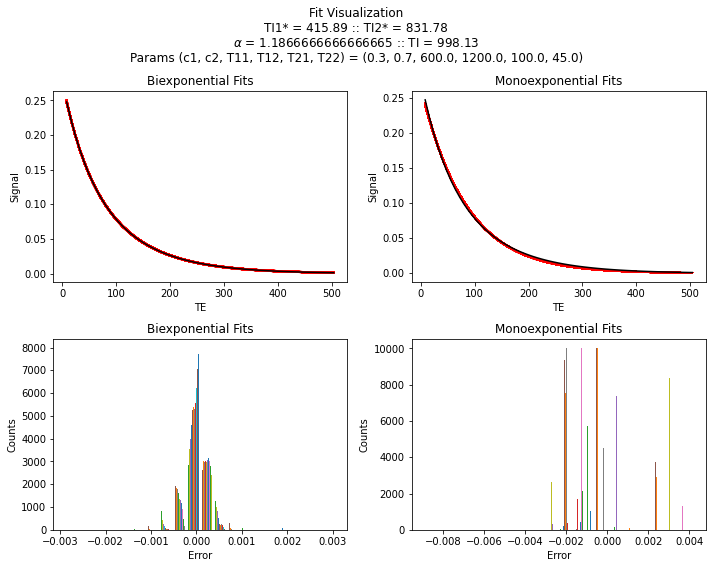

100%|██████████| 71/71 [6:39:40<00:00, 337.76s/it]


In [88]:
#Looping through all TI values in the TI_array
for k in trange(np.size(TI_array)):

    TI = TI_array[k]

    true_d1 = d_value(TI, c1, T11)
    true_d2 = d_value(TI, c2, T12)

    realParams = np.array([true_d1, true_d2, T21, T22])

    trueDat_4p = S_biX_4p(TE_series, *realParams)
    trueDat = S_biX_6p(TE_series, TI, T11, T12, c1, c2, T21, T22)

    assert(np.allclose(trueDat,trueDat_4p))
        
    i = 0
    #while loop so that if a lowest parameter value isn't found then we just do it again
    while i < iterCount:

        #Determining the noise and add noise to data
        noiseSigma = 1/SNR
        noise = np.random.normal(0,noiseSigma,TE_series.size)
        noiseDat = trueDat + noise

        lb = (-1,-1,0,0)
        ub = (1,1,T2_bound,T2_bound)
        init_p = realParams

        lb_1E = (-1,0)
        ub_1E = (1,T2_bound)
        init_p_1E = ((true_d1 + true_d2)/2 , (T21 + T22)/2)

        try:
            popt_2E, pcov_2E = curve_fit(lambda t_dat,p1,p2,p3,p4 : S_biX_4p(t_dat,p1,p2,p3,p4), TE_series, noiseDat, p0 = init_p, bounds = [lb,ub])
            popt_1E, pcov_1E = curve_fit(lambda t_dat,p1,p2 : S_moX_2p(t_dat,p1,p2), TE_series, noiseDat, p0 = init_p_1E, bounds = [lb_1E,ub_1E])
        except Exception as e:
            print(e)
            print("Rerunning this iteration = " + str(i))
            continue

        #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place
        if (popt_2E[3] > popt_2E[2]):
            p_hold = popt_2E[0]
            popt_2E[0] = popt_2E[1]
            popt_2E[1] = p_hold
            p_hold = popt_2E[2]
            popt_2E[2] = popt_2E[3]
            popt_2E[3] = p_hold

        paramStore_2E[k,i,:] = popt_2E
        paramStore_1E[k,i,:] = popt_1E

        #Calculate Condition Number
        B = Jacobian_4p(TE_series, *popt_2E) 
        covP = np.dot(B.T,B)*noiseSigma**2

        CN_params = np.reshape(np.diag(covP),(1,-1))
        CNStore[k,i,:] = CN_params

        #Calculate Residual Sum of Squares (RSS) of 2E
        est_Sig = S_biX_4p(TE_series,*popt_2E)
        RSS_Store[k,i] = np.sum((trueDat - est_Sig)**2)
        errStore[k,i] = np.linalg.norm(trueDat - est_Sig, ord = 2)
        sigStore_2E[k,i,:] = est_Sig

        #Calculate Residual Sum of Squares (RSS) of 1E
        est_Sig_1E = S_moX_2p(TE_series,*popt_1E)
        RSS_Store_1E[k,i] = np.sum((trueDat - est_Sig_1E)**2)
        errStore_1E[k,i] = np.linalg.norm(trueDat - est_Sig_1E, ord = 2)
        sigStore_1E[k,i,:] = est_Sig_1E

        i += 1 #iteration step

    avgCNStore[k,:] = np.reshape(np.mean(CNStore[k,:,:], axis = 0),(1,-1))
    avgPStore[k,:] = np.mean(paramStore_2E[k,:,:], axis = 0)
    stdStore[k,:] = np.std(paramStore_2E[k,:,:], axis = 0)
    std2Store[k,:] = np.var(paramStore_2E[k,:,:], axis = 0)**(1/2)
    mono_std[k,:] = np.std(paramStore_1E[k,:,:], axis = 0)

    if histPlot:
        fig, ax = plt.subplots(1,2, figsize=(9.5,5.5), tight_layout=True)
        for ii in range(2):

            #Get a good bin size
            binData = paramStore_2E[:,[2*ii,2*ii+1]]
            binData = np.reshape(binData,-1)
            binW = (np.max(binData) - np.min(binData))/12
            binW = float('%.1g' % binW) #converts everything to a single significant figure
            binMin = 10**(np.floor(np.log10(np.min(binData))))
            binArray = np.arange(binMin, np.max(binData) + binW, binW)

            #Construct a nice figure of each of the two 
            ax[ii].hist(x=paramStore_2E[:,2*ii], bins=binArray, color='b', label = ParamTitle_4p[2*ii], alpha = 0.7)
            ax[ii].hist(x=paramStore_2E[:,2*ii+1], bins=binArray, color='g', label = ParamTitle_4p[2*ii+1], alpha = 0.7)
            ax[ii].set_xlabel('Param Value')
            ax[ii].set_ylabel('Count')
            ax[ii].axvline(x=realParams[2*ii], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii], color='red')
            ax[ii].axvline(x=realParams[2*ii+1], linewidth=1, label= 'True ' + ParamTitle_4p[2*ii+1], color='orange')
            ax[ii].legend()
            ax[ii].set_title('Parameter Histogram Comparison' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) +
                        '\nTrue ' + ParamTitle_4p[2*ii] + '=' + str(round(realParams[2*ii],2)) + ' :: ' 
                        'True ' + ParamTitle_4p[2*ii+1] + '=' + str(round(realParams[2*ii+1],2)))
        fig.tight_layout()
        plt.show()

    if denPlot:
        fig, ax = plt.subplots(2,2, figsize=(10,8), tight_layout=True)

        fig.suptitle('Fit Visualization' + 
                        '\nTI1* = ' + str(round(TI1star,2)) + ' :: TI2* = ' + str(round(TI2star,2)) + 
                        '\n'+ r'$\alpha$'+ ' = ' + str(alpha_array[k]) + ' :: TI = ' + str(round(TI,2)) + 
                        '\nParams (' + pTitleList + ') = ' + '('+ pList + ')')
        
        for rep in range(iterCount):
            ax[0,0].plot(TE_series, sigStore_2E[k,rep,:], color='r', alpha = 0.5)
            ax[0,1].plot(TE_series, sigStore_1E[k,rep,:], color='r', alpha = 0.5)

        ax[0,0].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)
        ax[0,1].plot(TE_series, trueDat, label = "True Data", color='k', alpha = 1)

        ax[0,0].set_xlabel("TE")
        ax[0,1].set_xlabel("TE")
        ax[0,0].set_ylabel("Signal")
        ax[0,1].set_ylabel("Signal")
        ax[0,0].set_title("Biexponential Fits")
        ax[0,1].set_title("Monoexponential Fits")

        ax[1,0].hist(x = (sigStore_2E[k,:,:] - trueDat), bins = 20)
        ax[1,1].hist(x = (sigStore_1E[k,:,:] - trueDat), bins = 20)

        ax[1,0].set_xlabel("Error")
        ax[1,1].set_xlabel("Error")
        ax[1,0].set_ylabel("Counts")
        ax[1,1].set_ylabel("Counts")
        ax[1,0].set_title("Biexponential Fits")
        ax[1,1].set_title("Monoexponential Fits")

        plt.show()

# Plotting

### Standard Deviation

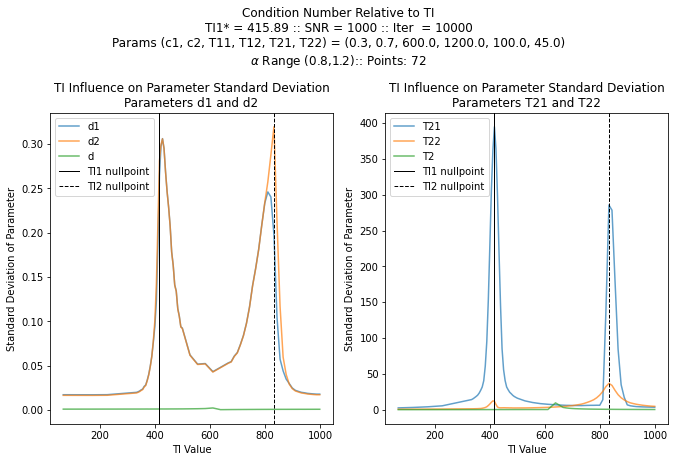

In [96]:
if stdPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Condition Number Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,stdStore[:,2*i], label = ParamTitle_4p[2*i], alpha = 0.7)
        ax[i].plot(TI_array,stdStore[:,2*i+1], label = ParamTitle_4p[2*i+1], alpha = 0.7)
        ax[i].plot(TI_array,mono_std[:,i], label = MonoTitle[i], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Standard Deviation of Parameter')
        ax[i].set_title('TI Influence on Parameter Standard Deviation' + '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
        ax[i].legend()
    plt.show()

### Condition Number Plots

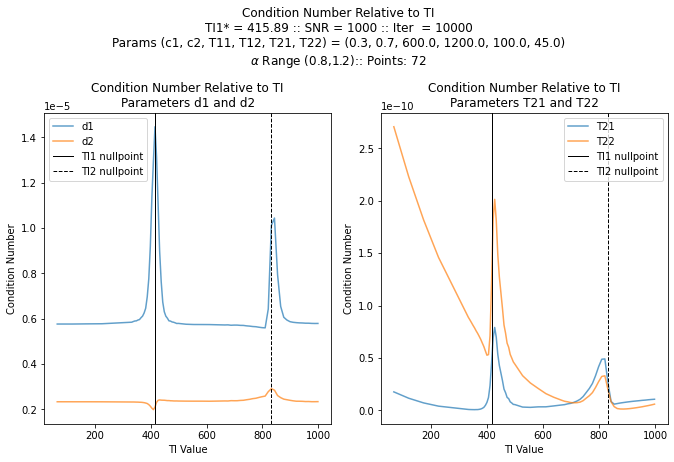

In [95]:
if cNPlot:
    fig, ax = plt.subplots(1,2, figsize=(9.5,6.5), tight_layout=True)
    fig.suptitle('Condition Number Relative to TI' + details)
    for i in range(2):
        ax[i].plot(TI_array,avgCNStore[:,2*i], label = ParamTitle_4p[2*i], alpha = 0.7)
        ax[i].plot(TI_array,avgCNStore[:,2*i+1], label = ParamTitle_4p[2*i+1], alpha = 0.7)
        ax[i].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
        ax[i].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
        ax[i].set_xlabel('TI Value')
        ax[i].set_ylabel('Condition Number')
        ax[i].set_title('Condition Number Relative to TI' +
                            '\nParameters ' + ParamTitle_4p[2*i] + ' and ' + ParamTitle_4p[2*i+1])
        ax[i].legend()
    plt.show()


### Residual Sum of Squares Plot

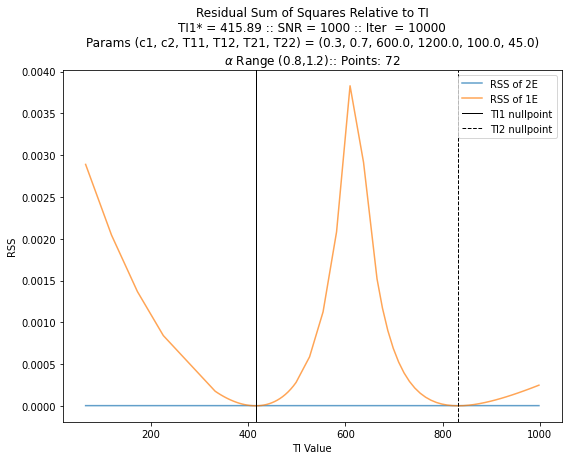

In [91]:
RSS_avg = np.mean(RSS_Store,axis = 1)
RSS_avg_1E = np.mean(RSS_Store_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,RSS_avg, label = 'RSS of 2E', alpha = 0.7)
plt.plot(TI_array,RSS_avg_1E, label = 'RSS of 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('RSS')
plt.title('Residual Sum of Squares Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### L2 Norm Plot

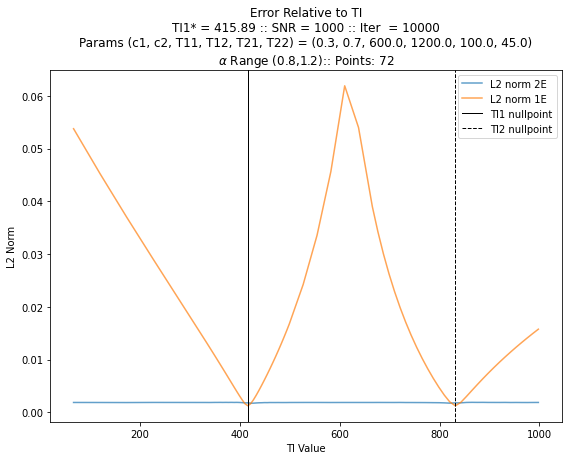

In [92]:
Err_avg = np.mean(errStore,axis = 1)
Err_avg_1E = np.mean(errStore_1E,axis = 1)
fig = plt.figure(figsize=(8,6.5), tight_layout=True)
plt.plot(TI_array,Err_avg, label = 'L2 norm 2E', alpha = 0.7)
plt.plot(TI_array,Err_avg_1E, label = 'L2 norm 1E', alpha = 0.7)
plt.axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
plt.axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
plt.xlabel('TI Value')
plt.ylabel('L2 Norm')
plt.title('Error Relative to TI' + details)
plt.legend()
plt.tight_layout()
plt.show()

### Information Criteria - AIC, BIC, R2, Cp

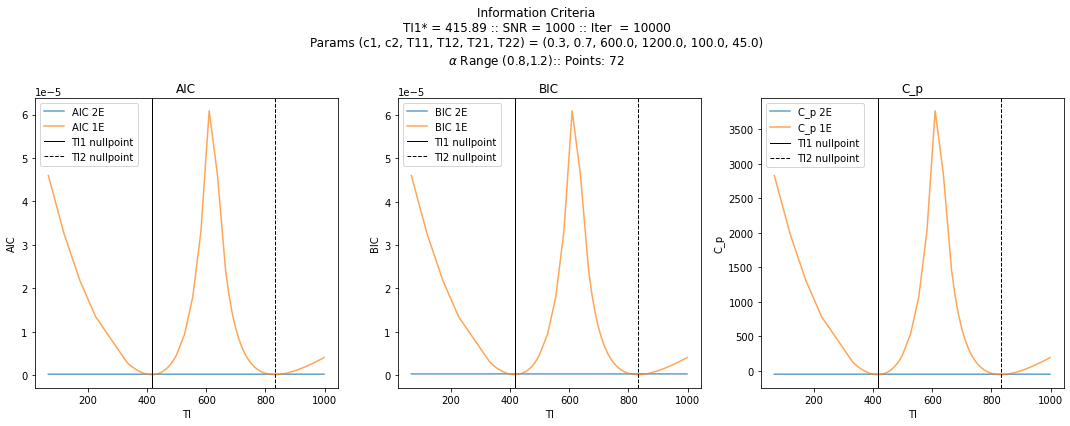

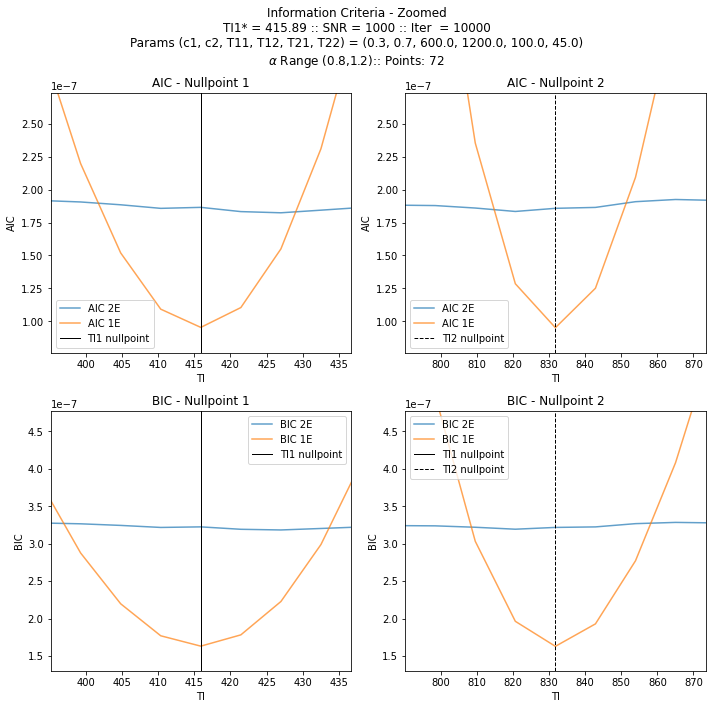

In [104]:
AIC_2E = 1/TE_series.shape[0] * (RSS_avg + 2 * np.size(ParamTitle_4p)*noiseSigma**2)
AIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + 2 * np.size(MonoTitle)*noiseSigma**2)

BIC_2E = 1/TE_series.shape[0] * (RSS_avg + np.log(TE_series.shape[0]) * np.size(ParamTitle_4p)*noiseSigma**2)
BIC_1E = 1/TE_series.shape[0] * (RSS_avg_1E + np.log(TE_series.shape[0]) * np.size(MonoTitle)*noiseSigma**2)

Cp_2E = RSS_avg/noiseSigma**2 + 2*np.size(ParamTitle_4p) - TE_series.shape[0]
Cp_1E = RSS_avg_1E/noiseSigma**2 + 2*np.size(MonoTitle) - TE_series.shape[0]

fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
fig.suptitle('Information Criteria' + details)


ax[0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0].set_title('AIC')
ax[0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0].set_xlabel('TI')
ax[0].set_ylabel('AIC')
ax[0].legend()

ax[1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1].set_title('BIC')
ax[1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1].set_xlabel('TI')
ax[1].set_ylabel('BIC')
ax[1].legend()

ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
ax[2].set_title('C_p')
ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[2].set_xlabel('TI')
ax[2].set_ylabel('C_p')
ax[2].legend()

fig, ax = plt.subplots(2,2,figsize=(10,10), tight_layout=True)
fig.suptitle('Information Criteria - Zoomed' + details)

minVal_1E = min(AIC_1E)
minVal_2E = min(AIC_2E)
ax[0,0].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,0].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,0].set_title('AIC - Nullpoint 1')
ax[0,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[0,0].set_xlabel('TI')
ax[0,0].set_ylabel('AIC')
ax[0,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[0,0].legend()

ax[0,1].plot(TI_array, AIC_2E, label = 'AIC 2E', alpha = 0.7)
ax[0,1].plot(TI_array, AIC_1E, label = 'AIC 1E', alpha = 0.7)
ax[0,1].set_title('AIC - Nullpoint 2')
ax[0,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[0,1].set_xlabel('TI')
ax[0,1].set_ylabel('AIC')
ax[0,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[0,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[0,1].legend()

minVal_1E = min(BIC_1E)
minVal_2E = min(BIC_2E)
ax[1,0].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,0].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,0].set_title('BIC - Nullpoint 1')
ax[1,0].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,0].set_xlabel('TI')
ax[1,0].set_ylabel('BIC')
ax[1,0].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,0].set_xlim([(1-rad)*TI1star, (1+rad)*TI1star])
ax[1,0].legend()

ax[1,1].plot(TI_array, BIC_2E, label = 'BIC 2E', alpha = 0.7)
ax[1,1].plot(TI_array, BIC_1E, label = 'BIC 1E', alpha = 0.7)
ax[1,1].set_title('BIC - Nullpoint 2')
ax[1,1].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
ax[1,1].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
ax[1,1].set_xlabel('TI')
ax[1,1].set_ylabel('BIC')
ax[1,1].set_ylim([0.8*minVal_1E,1.5*minVal_2E])
ax[1,1].set_xlim([(1-rad)*TI2star, (1+rad)*TI2star])
ax[1,1].legend()

# minVal_1E = min(Cp_1E)
# minVal_2E = min(Cp_2E)
# ax[2].plot(TI_array, Cp_2E, label = 'C_p 2E', alpha = 0.7)
# ax[2].plot(TI_array, Cp_1E, label = 'C_p 1E', alpha = 0.7)
# ax[2].set_title('C_p')
# ax[2].axvline(x=TI1star, linewidth=1, label= 'TI1 nullpoint', color='k')
# ax[2].axvline(x=TI2star, linewidth=1, label= 'TI2 nullpoint', color='k', ls = '--')
# ax[2].set_xlabel('TI')
# ax[2].set_ylabel('C_p')
# ax[2].set_ylim(1.2*minVal_1E,0.5*minVal_2E)
# ax[2].legend()


### Sensitivity Graphs

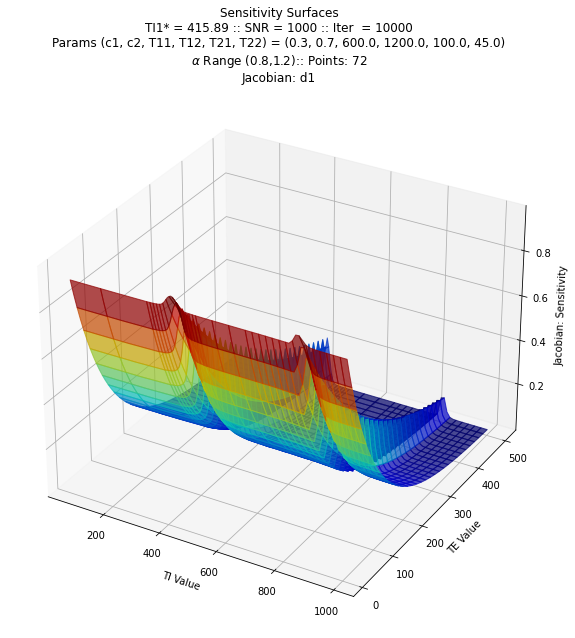

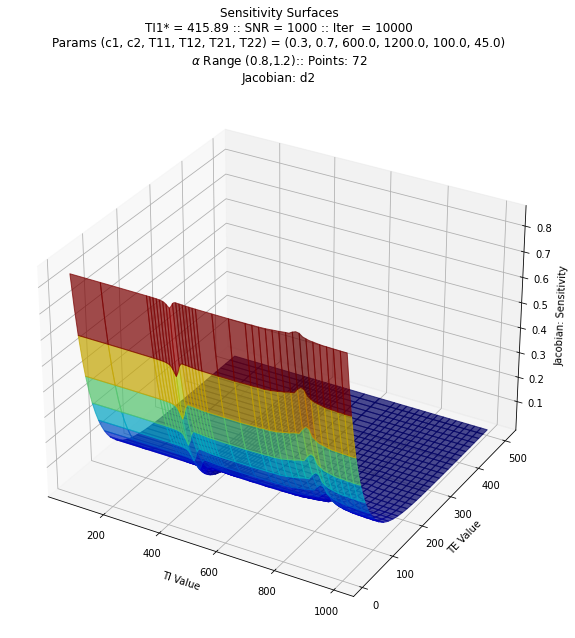

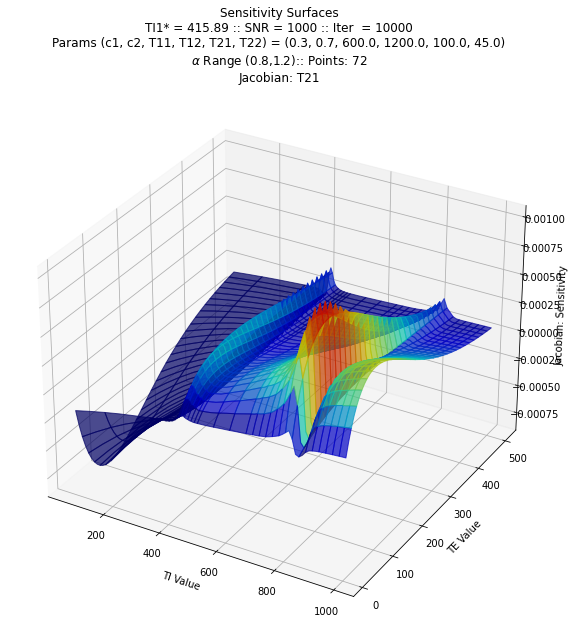

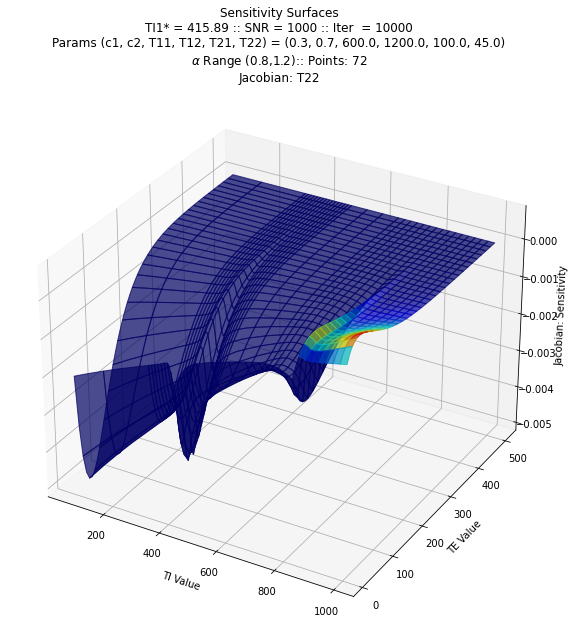

<Figure size 432x288 with 0 Axes>

In [94]:
TImg,TEmg = np.meshgrid(TI_array,TE_series)
Jstore = np.zeros((TImg.shape[0],TImg.shape[1],np.size(ParamTitle_4p)))
for i in range(Jstore.shape[0]):
    for j in range(Jstore.shape[1]):
        Jstore[i,j,:] = Jacobian_4p(TEmg[i,j],*avgPStore[j,:])



for j in range(Jstore.shape[2]):
    fig = plt.figure(figsize = (10,10))
    ax = plt.axes(projection='3d')
    my_col = cm.jet(Jstore[:,:,j]/np.amax(Jstore[:,:,j]))
    ax.plot_surface(TImg,TEmg,Jstore[:,:,j], alpha = 0.7, facecolors = my_col)
    ax.set_xlabel('TI Value')
    ax.set_ylabel('TE Value')
    ax.set_zlabel('Jacobian: Sensitivity')
    ax.set_title('Sensitivity Surfaces' + details + '\nJacobian: ' + ParamTitle_4p[j])
    plt.show()



plt.tight_layout()
plt.show()